# Import Libraries

In [3]:
import numpy as np
import pandas as pd
import awkward as ak

import seaborn as sns
import matplotlib.pyplot as plt

import sklearn
import uproot

from tqdm import tqdm
import timeit
import os

import dill

# For building k-NN and adjacency
from scipy.spatial import cKDTree
import scipy.sparse as sp
import pickle
import networkx as nx

import torch
if torch.cuda.is_available():
    print(f"CUDA available: {torch.cuda.is_available()}")
    device = torch.device("cuda")  # Set device to CUDA if available
    print(f"Using device: {device}")
    print(f"Torch version: {torch.__version__}")
    print(f"CUDA version: {torch.version.cuda}")  # CUDA version PyTorch was compiled with
    print(f"cuDNN version: {torch.backends.cudnn.version()}")  # cuDNN version
    print(f"Number of GPUs: {torch.cuda.device_count()}")  # GPU count
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")  # GPU name

import dgl
# Print the installed DGL version
print(f"DGL version: {dgl.__version__}")
print(f"DGL Backend: {dgl.backend.backend_name}")

CUDA available: True
Using device: cuda
Torch version: 2.4.0+cu124
CUDA version: 12.4
cuDNN version: 90100
Number of GPUs: 1
GPU Name: NVIDIA GeForce RTX 2080 Ti
DGL version: 2.4.0+cu124
DGL Backend: pytorch


# Check the file 

In [4]:
import uproot

filepath = "./data/JetClass/JetRoots/JetClass_example_100k.root"  # Path to ROOT file

# Open ROOT file
file = uproot.open(filepath)

# Print all tree names
print("Available Trees:", file.keys())

# Open the main tree (assuming it's named 'tree')
tree = file["tree"]

# Print all branches (columns) available in the ROOT file
print("Available Branches (Columns):", tree.keys())


Available Trees: ['tree;5']
Available Branches (Columns): ['part_px', 'part_py', 'part_pz', 'part_energy', 'part_deta', 'part_dphi', 'part_d0val', 'part_d0err', 'part_dzval', 'part_dzerr', 'part_charge', 'part_isChargedHadron', 'part_isNeutralHadron', 'part_isPhoton', 'part_isElectron', 'part_isMuon', 'label_QCD', 'label_Hbb', 'label_Hcc', 'label_Hgg', 'label_H4q', 'label_Hqql', 'label_Zqq', 'label_Wqq', 'label_Tbqq', 'label_Tbl', 'jet_pt', 'jet_eta', 'jet_phi', 'jet_energy', 'jet_nparticles', 'jet_sdmass', 'jet_tau1', 'jet_tau2', 'jet_tau3', 'jet_tau4', 'aux_genpart_eta', 'aux_genpart_phi', 'aux_genpart_pid', 'aux_genpart_pt', 'aux_truth_match']


#  Classwise Graph GeneratioNn

In [7]:
import numpy as np
import pandas as pd
import awkward as ak
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import uproot
import torch
from tqdm import tqdm
import timeit
import os
import dill
from scipy.spatial import cKDTree
import scipy.sparse as sp
import dgl
import pickle

# ------------------------------------------------------------------
# FUNCTIONS
# ------------------------------------------------------------------

# Take ROOT file and convert to an awkward array
def fileToAwk(path):
    file = uproot.open(path)
    tree = file['tree']
    awk = tree.arrays(tree.keys())
    return awk

# Features used to train the model
input_features = [
    "part_px", "part_py", "part_pz", "part_energy",
    "part_deta", "part_dphi", "part_d0val", "part_d0err",
    "part_dzval", "part_dzerr", "part_isChargedHadron", "part_isNeutralHadron",
    "part_isPhoton", "part_isElectron", "part_isMuon"
]

# Take AWK dict and convert to a point cloud
def awkToPointCloud(awkDict, input_features, label):
    featureVector = []
    for jet in tqdm(range(len(awkDict)), total=len(awkDict)):
        if awkDict[jet][label] == 1:  # Filter jets based on the label
            currJet = awkDict[jet][input_features]
            try:
                pT = np.sqrt(ak.to_numpy(currJet['part_px']) ** 2 + ak.to_numpy(currJet['part_py']) ** 2)
                # Create numpy array to represent the 4-momenta of all particles in a jet
                currJet = np.column_stack((
                    ak.to_numpy(currJet['part_px']),
                    ak.to_numpy(currJet['part_py']),
                    ak.to_numpy(currJet['part_pz']),
                    ak.to_numpy(currJet['part_energy']),
                    pT,
                    ak.to_numpy(currJet['part_deta']),
                    ak.to_numpy(currJet['part_dphi']),
                    ak.to_numpy(currJet["part_d0val"]),
                    ak.to_numpy(currJet["part_d0err"]),
                    ak.to_numpy(currJet["part_dzval"]),
                    ak.to_numpy(currJet["part_dzerr"]),
                    ak.to_numpy(currJet["part_isChargedHadron"]),
                    ak.to_numpy(currJet["part_isNeutralHadron"]),
                    ak.to_numpy(currJet["part_isPhoton"]),
                    ak.to_numpy(currJet["part_isElectron"]),
                    ak.to_numpy(currJet["part_isMuon"])
                ))
                featureVector.append(currJet)
            except Exception as e:
                print(f"Error processing jet {jet}: {e}")
                featureVector.append(np.empty((0, len(input_features) + 1)))  # Add an empty array for failed jets
    return featureVector  # Return a list of arrays instead of a single numpy array

# Build a KNN graph from a point cloud
def buildKNNGraph(points, k):
    tree = cKDTree(points)
    dists, indices = tree.query(points, k+1)  # +1 to exclude self

    num_points = len(points)
    adj_matrix = np.zeros((num_points, num_points))
    for i in range(num_points):
        for j in indices[i, 1:]:  # exclude self
            adj_matrix[i, j] = 1
            # adj_matrix[j, i] = 1
    return adj_matrix

# Convert adjacency matrix to a DGL graph
def adjacencyToDGL(adj_matrix):
    adj_matrix = sp.coo_matrix(adj_matrix)
    g_dgl = dgl.from_scipy(adj_matrix)
    return g_dgl

# Wrap the functionality of fileToAwk and awkToPointCloud into a single function
def fileToPointCloudArray(jetType, input_features, label):
    filepath = f'./data/JetClass/JetRoots/JetClass_example_100k.root'  # original ROOT file
    savepath = f'./data/JetClass/PointClouds/{jetType}.npy'   # save file
    awk = fileToAwk(filepath)
    nparr = awkToPointCloud(awk, input_features, label)
    return nparr

# Combine all steps: read file → build adjacency → build DGL graph → optionally save
def fileToGraph(jetType, label, k=3, save=True):
    print(f'Starting processing on {jetType} jets with label {label}')
    pointCloudArr = fileToPointCloudArray(jetType, input_features, label)
    saveFilePath = f'./data/Multi Level Jet Tagging/{jetType}.pkl'

    savedGraphs = []
    for idx, pointCloud in tqdm(enumerate(pointCloudArr), leave=False, total=len(pointCloudArr)):
        try:
            adj_matrix = buildKNNGraph(pointCloud, k)
            graph = adjacencyToDGL(adj_matrix)
            graph.ndata['feat'] = torch.tensor(pointCloud, dtype=torch.float32)
            savedGraphs.append(graph)

            # Cleanup
            del adj_matrix, graph
        except Exception as e:
            print(e)

    if save:
        with open(saveFilePath, 'wb') as f:
            pickle.dump(savedGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)

        del pointCloudArr, savedGraphs

    print(f'Graphs for {jetType} processing complete!')
    return savedGraphs

def groupToGraph(jetTypeList, groupName, label):
    allGraphs = []
    for jetType in jetTypeList:
        allGraphs += fileToGraph(jetType, label, save=False)

    saveFilePath = f'./data/Multi Level Jet Tagging/{groupName}.pkl'
    with open(saveFilePath, 'wb') as f:
        pickle.dump(allGraphs, f, protocol=pickle.HIGHEST_PROTOCOL)
    return allGraphs

# Dictionary of jet types and their respective labels
jet_types = {
    "Higgs_HToBB": ['HToBB', 'label_Hbb'],
    "Higgs_HToCC": ['HToCC', 'label_Hcc'],
    "Higgs_HToGG": ['HToGG', 'label_Hgg'],
    "Higgs_HToWW2Q1L": ['HToWW2Q1L', 'label_Hqql'],
    "Higgs_HToWW4Q": ['HToWW4Q', 'label_H4q'],
    "Vector_WToQQ": ['WToQQ', 'label_Wqq'],
    "Vector_ZToQQ": ['ZToQQ', 'label_Zqq'],
    "Top_TTBar": ['TTBar', 'label_Tbqq'],
    "Top_TTBarLep": ['TTBarLep', 'label_Tbl'],
    "QCD_ZJetsToNuNu": ['ZJetsToNuNu', 'label_QCD']
}

# Loop through each jet type, generate graphs, and save them
for key, value in jet_types.items():
    jetType, label = value
    graphs = groupToGraph([jetType], f"Emitter-{key}", label)
    
    # Save each graph to a file
    with open(f'./data/Multi Level Jet Tagging/Emitter-{key}.pkl', 'wb') as f:
        pickle.dump(graphs, f)
    
    print(f"DONE: {key}")

Starting processing on HToBB jets with label label_Hbb


100%|██████████| 100000/100000 [00:17<00:00, 5788.12it/s]


Graphs for HToBB processing complete!
DONE: Higgs_HToBB
Starting processing on HToCC jets with label label_Hcc


100%|██████████| 100000/100000 [00:17<00:00, 5762.79it/s]


Graphs for HToCC processing complete!
DONE: Higgs_HToCC
Starting processing on HToGG jets with label label_Hgg


100%|██████████| 100000/100000 [00:17<00:00, 5732.93it/s]


Graphs for HToGG processing complete!
DONE: Higgs_HToGG
Starting processing on HToWW2Q1L jets with label label_Hqql


 14%|█▍        | 1391/10000 [00:00<00:02, 3483.05it/s]

index 3 is out of bounds for axis 1 with size 3


 49%|████▉     | 4899/10000 [00:01<00:01, 3476.84it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for HToWW2Q1L processing complete!
DONE: Higgs_HToWW2Q1L
Starting processing on HToWW4Q jets with label label_H4q


100%|██████████| 100000/100000 [00:17<00:00, 5671.68it/s]


Graphs for HToWW4Q processing complete!
DONE: Higgs_HToWW4Q
Starting processing on WToQQ jets with label label_Wqq


100%|██████████| 100000/100000 [00:17<00:00, 5736.77it/s]


Graphs for WToQQ processing complete!
DONE: Vector_WToQQ
Starting processing on ZToQQ jets with label label_Zqq


100%|██████████| 100000/100000 [00:17<00:00, 5803.20it/s]


Graphs for ZToQQ processing complete!
DONE: Vector_ZToQQ
Starting processing on TTBar jets with label label_Tbqq


100%|██████████| 100000/100000 [00:17<00:00, 5828.91it/s]


Graphs for TTBar processing complete!
DONE: Top_TTBar
Starting processing on TTBarLep jets with label label_Tbl


 71%|███████   | 7113/10000 [00:02<00:00, 3548.76it/s]

index 3 is out of bounds for axis 1 with size 3


Graphs for TTBarLep processing complete!
DONE: Top_TTBarLep
Starting processing on ZJetsToNuNu jets with label label_QCD


100%|██████████| 100000/100000 [00:16<00:00, 5884.78it/s]


Graphs for ZJetsToNuNu processing complete!
DONE: QCD_ZJetsToNuNu


# Test portion

In [8]:
import pickle
import os

# Directory containing the generated files
directory = "./data/Multi Level Jet Tagging"

# List all .pkl files in the directory
pkl_files = [f for f in os.listdir(directory) if f.endswith(".pkl")]

# Iterate through each file and count the number of graphs
for pkl_file in pkl_files:
    file_path = os.path.join(directory, pkl_file)
    
    with open(file_path, "rb") as f:
        graphs = pickle.load(f)
    
    print(f"{pkl_file}: {len(graphs)} graphs")


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Emitter-Vector_WToQQ.pkl: 10000 graphs
Emitter-Higgs_HToWW4Q.pkl: 10000 graphs
Emitter-Higgs_HToBB.pkl: 10000 graphs
Emitter-Top_TTBarLep.pkl: 9999 graphs
Emitter-Higgs_HToCC.pkl: 10000 graphs
Emitter-Higgs_HToGG.pkl: 10000 graphs
Emitter-Vector_ZToQQ.pkl: 10000 graphs
Emitter-Top_TTBar.pkl: 10000 graphs
Emitter-QCD_ZJetsToNuNu.pkl: 10000 graphs
Emitter-Higgs_HToWW2Q1L.pkl: 9998 graphs


# First 2 Graphs

Loading graphs from: Emitter-Higgs_HToBB.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


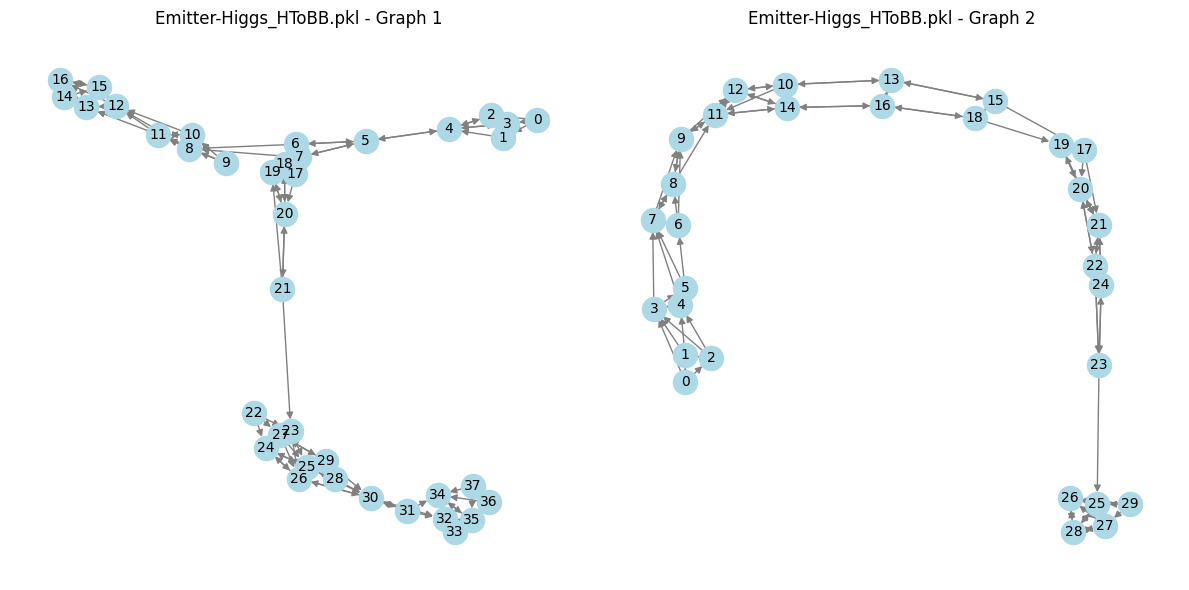

Loading graphs from: Emitter-Higgs_HToCC.pkl


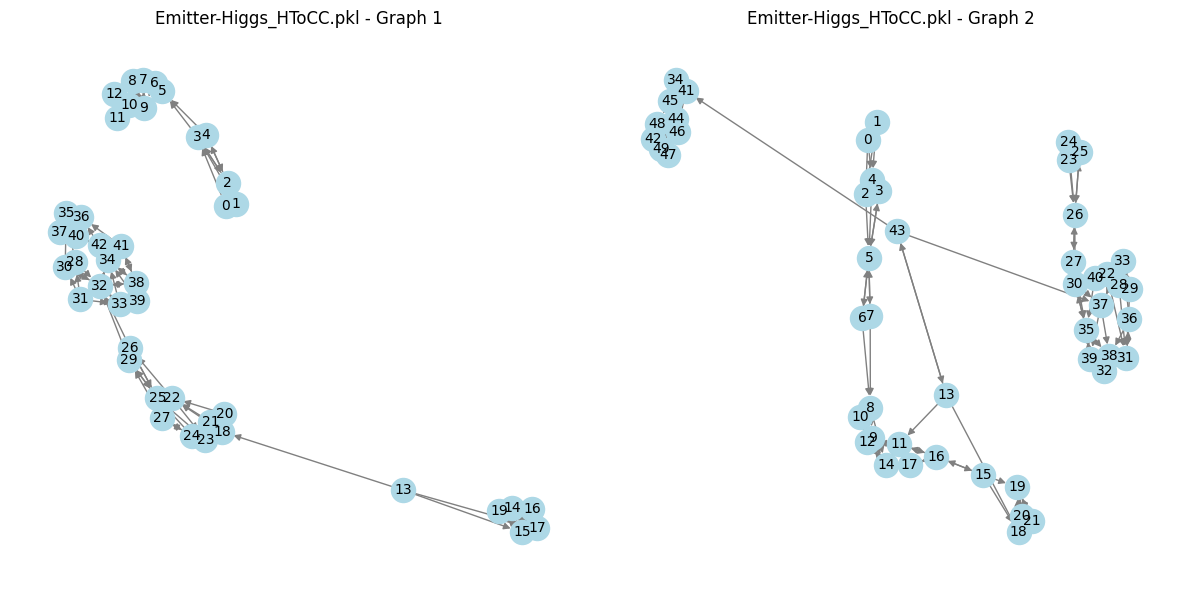

Loading graphs from: Emitter-Higgs_HToGG.pkl


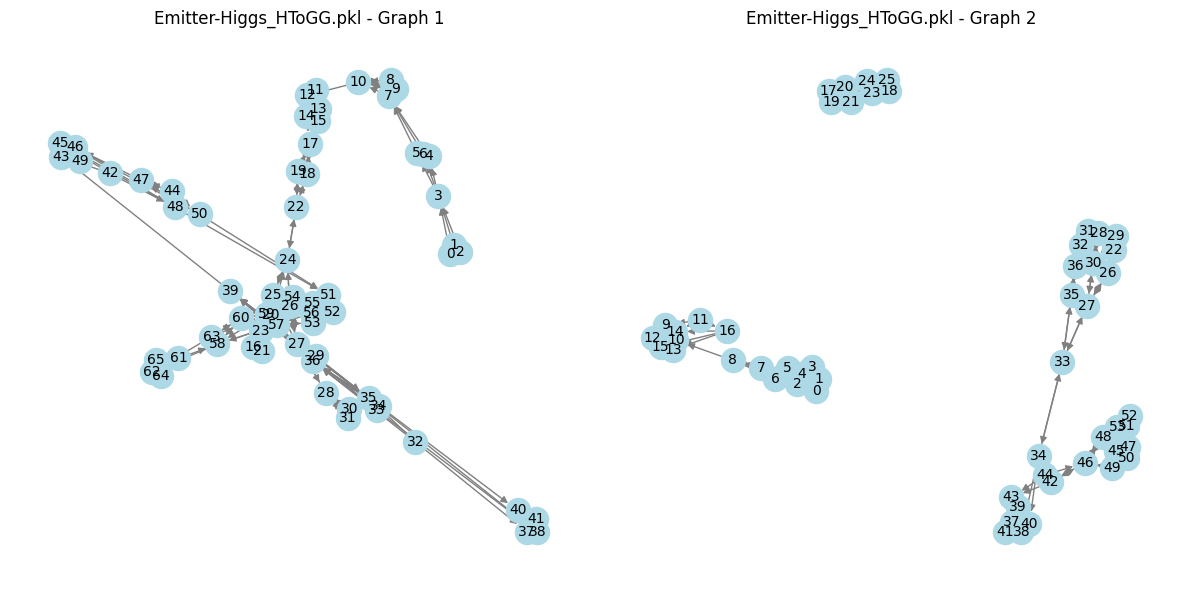

Loading graphs from: Emitter-Higgs_HToWW2Q1L.pkl


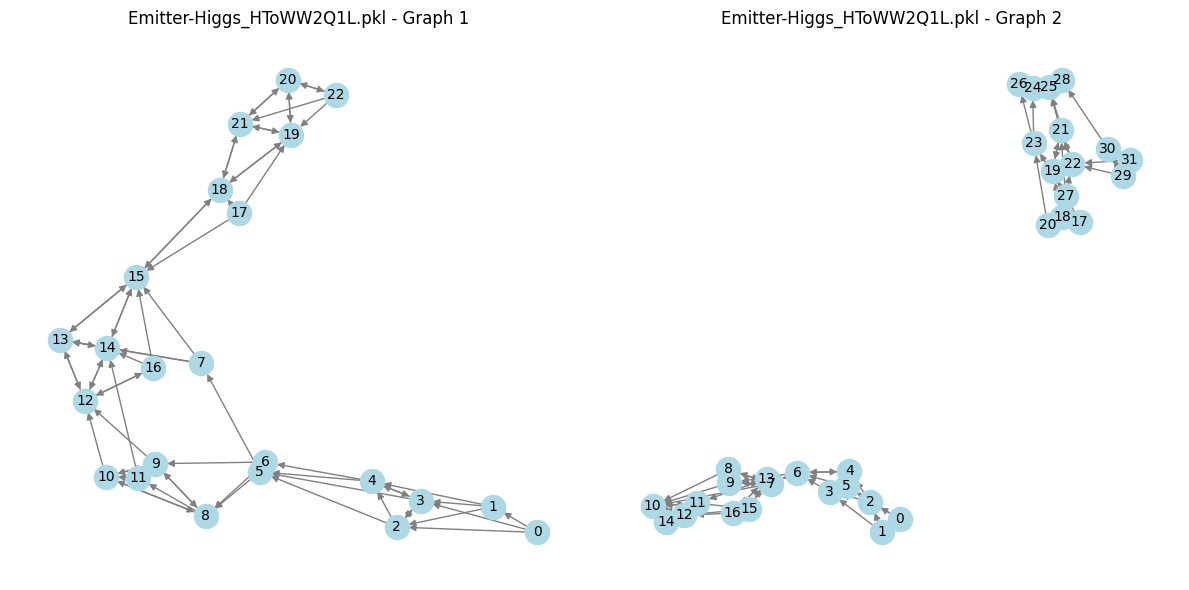

Loading graphs from: Emitter-Higgs_HToWW4Q.pkl


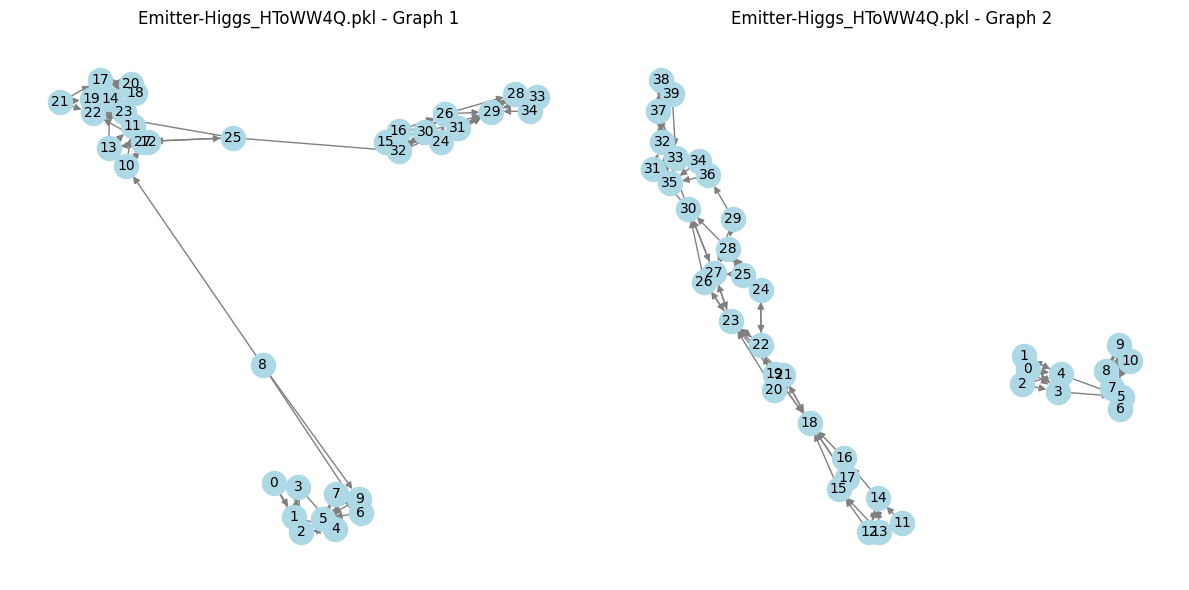

Loading graphs from: Emitter-QCD_ZJetsToNuNu.pkl


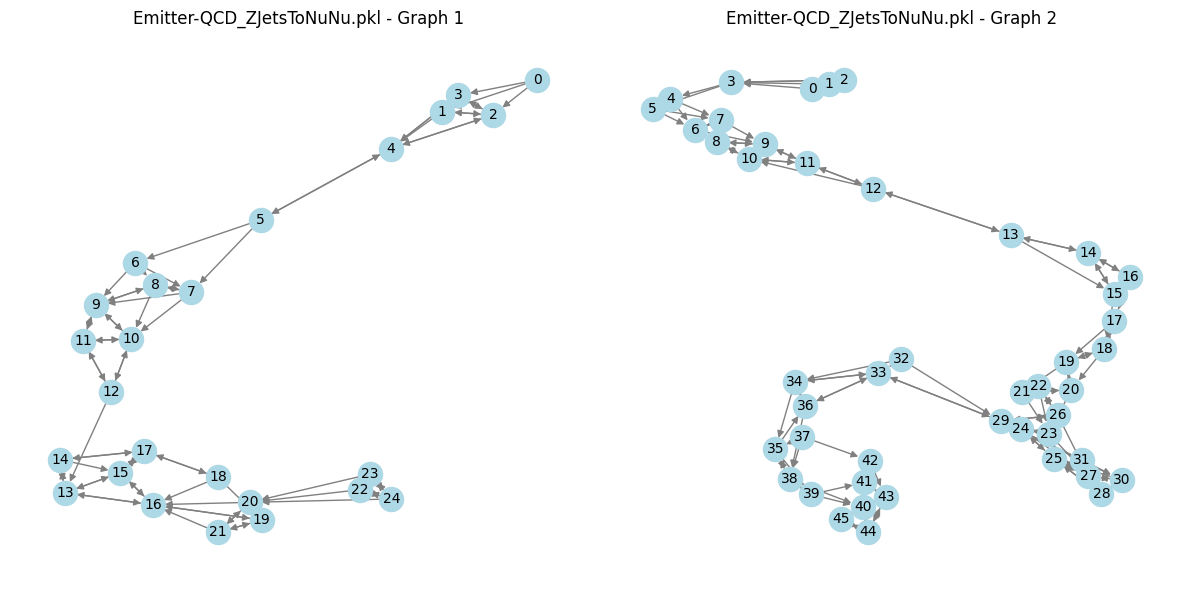

Loading graphs from: Emitter-Top_TTBar.pkl


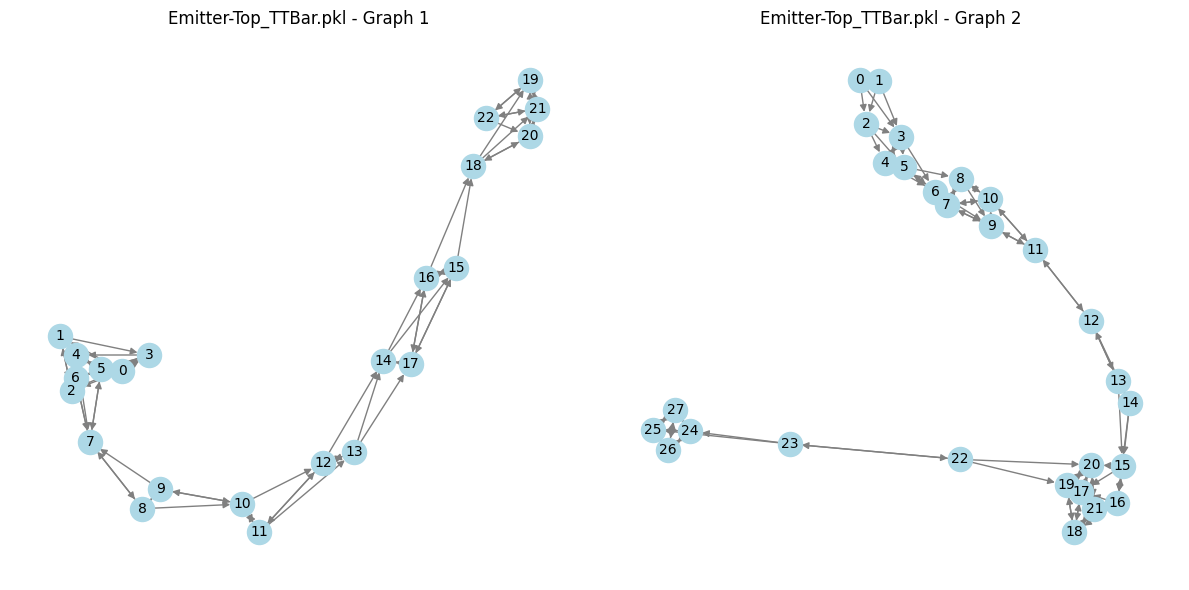

Loading graphs from: Emitter-Top_TTBarLep.pkl


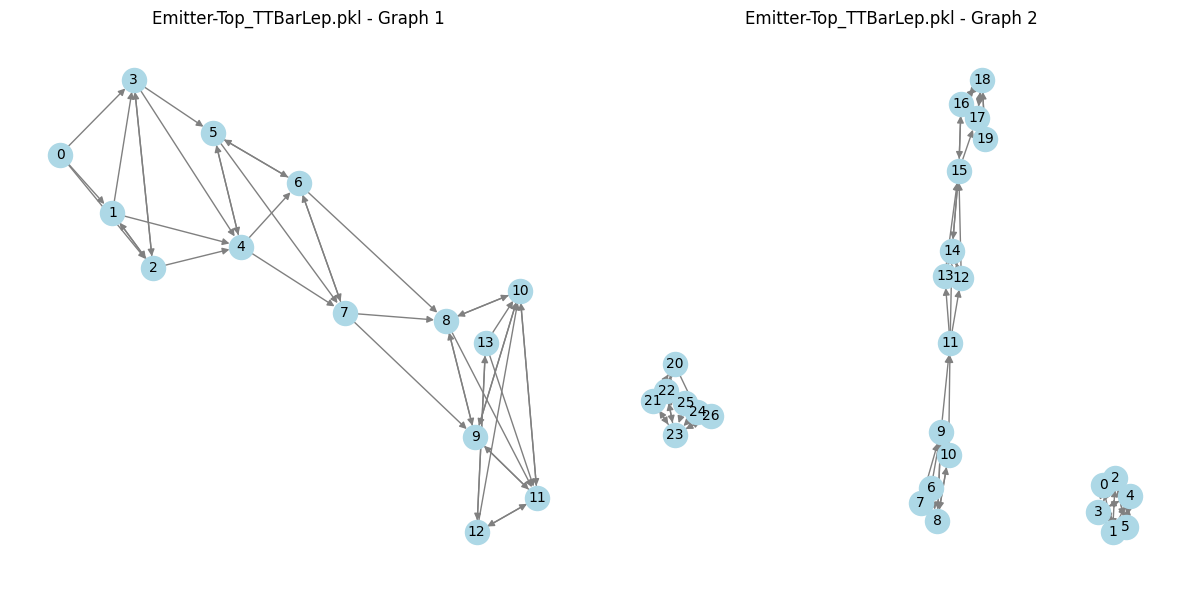

Loading graphs from: Emitter-Vector_WToQQ.pkl


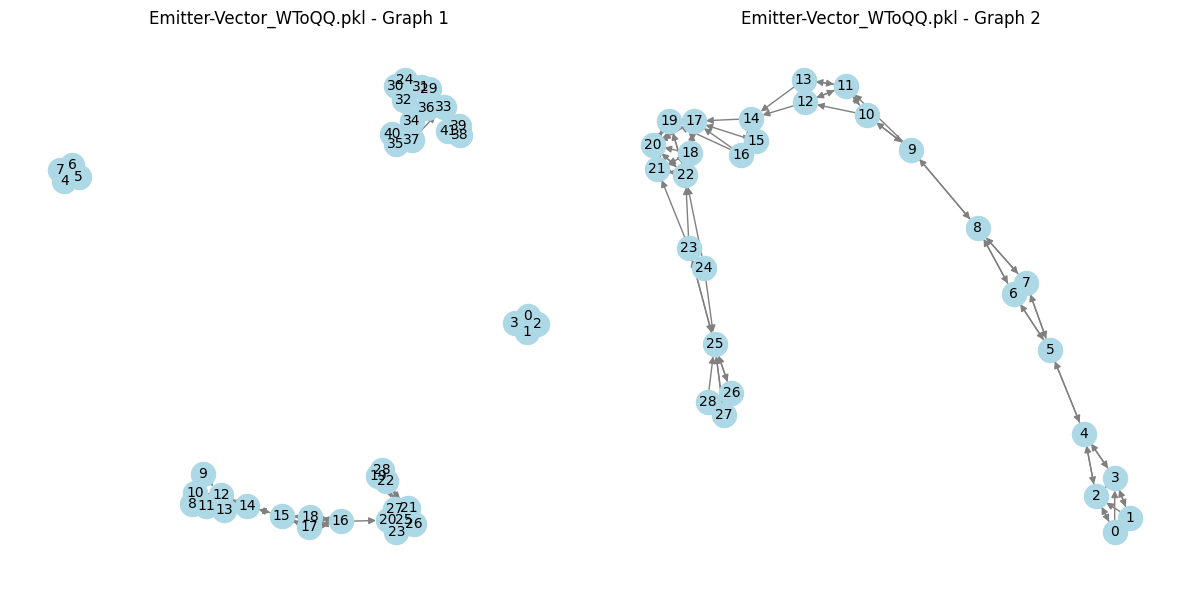

Loading graphs from: Emitter-Vector_ZToQQ.pkl


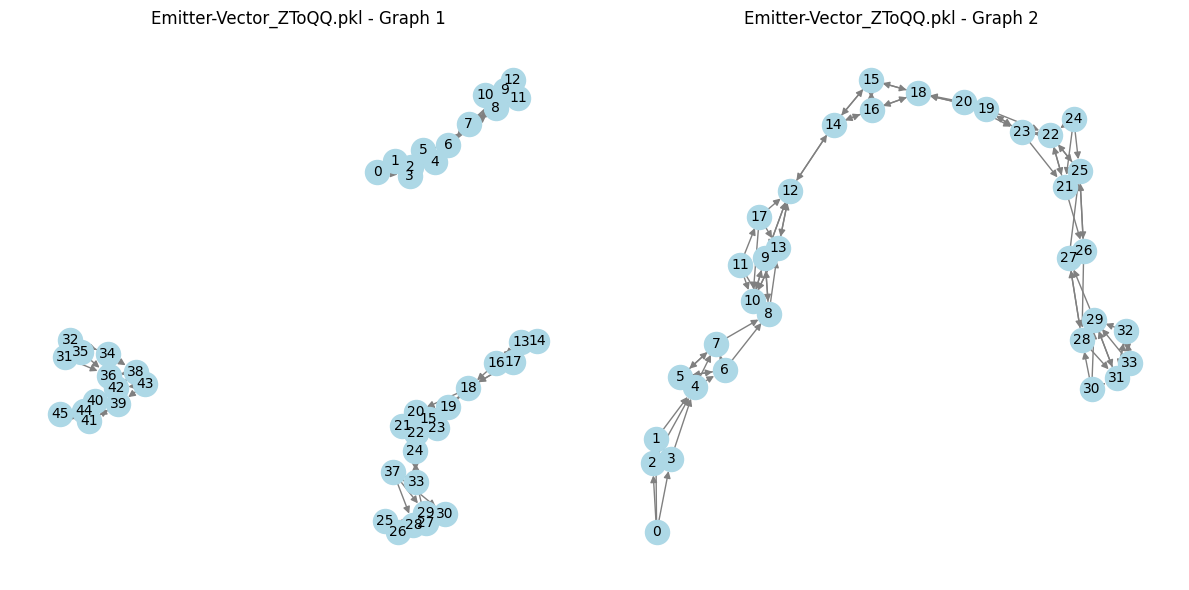

In [1]:
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt
import dgl

# Path to the directory containing the graph files
file_path = './data/Multi Level Jet Tagging/'

# Get a list of all files in the directory
files = sorted([f for f in os.listdir(file_path) if f.endswith('.pkl')])

# Function to visualize multiple DGL graphs side-by-side
def visualize_dgl_graphs_side_by_side(dgl_graphs, titles):
    num_graphs = len(dgl_graphs)
    plt.figure(figsize=(6 * num_graphs, 6))  # Adjust width based on the number of graphs
    
    for i, (graph, title) in enumerate(zip(dgl_graphs, titles)):
        plt.subplot(1, num_graphs, i + 1)
        nx_graph = dgl.to_networkx(graph)
        pos = nx.spring_layout(nx_graph)  # Layout for better visualization
        nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=10)
        plt.title(title)
    
    plt.tight_layout()
    plt.show()


# Loop through each file and visualize the first 2 graphs side-by-side
for file in files:
    file_full_path = os.path.join(file_path, file)
    print(f"Loading graphs from: {file}")
    
    # Load the graphs from the file
    with open(file_full_path, 'rb') as f:
        graphs = pickle.load(f)
    
    # Visualize the first 2 graphs side-by-side
    if len(graphs) >= 2:
        visualize_dgl_graphs_side_by_side(graphs[:2], titles=[f"{file} - Graph {i+1}" for i in range(2)])


# First 5 graphs

Loading graphs from: Emitter-Higgs_HToBB.pkl


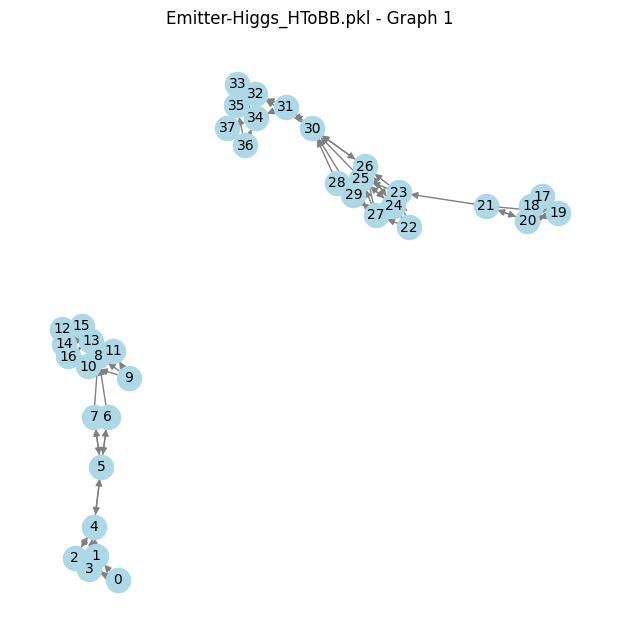

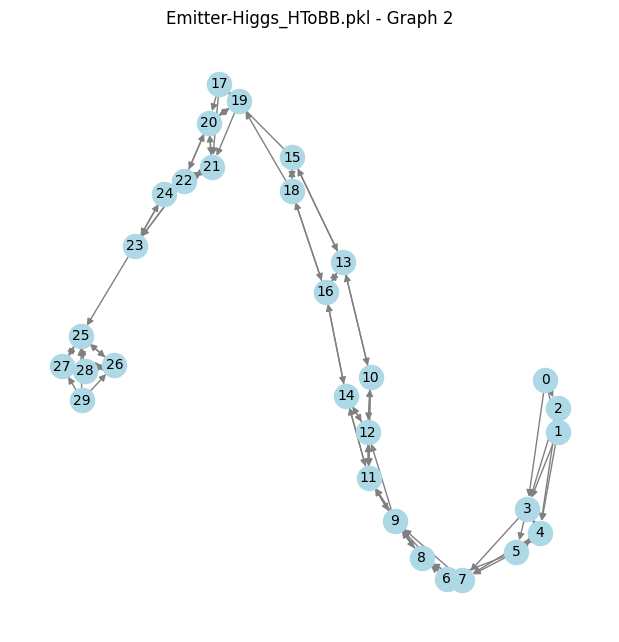

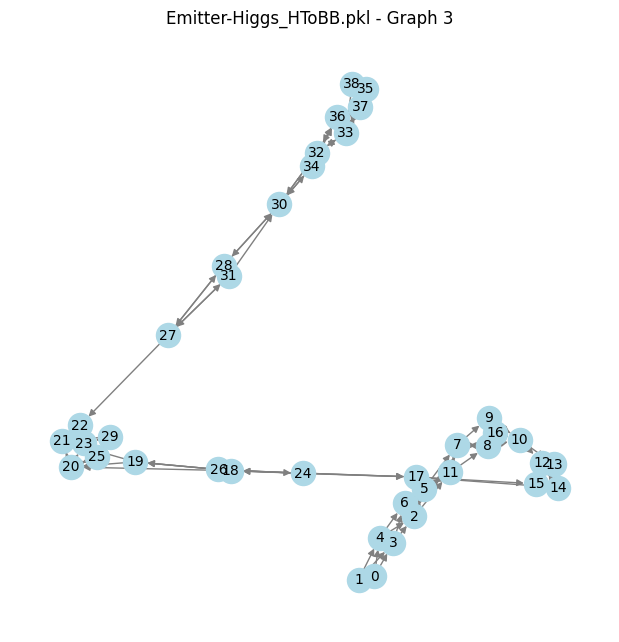

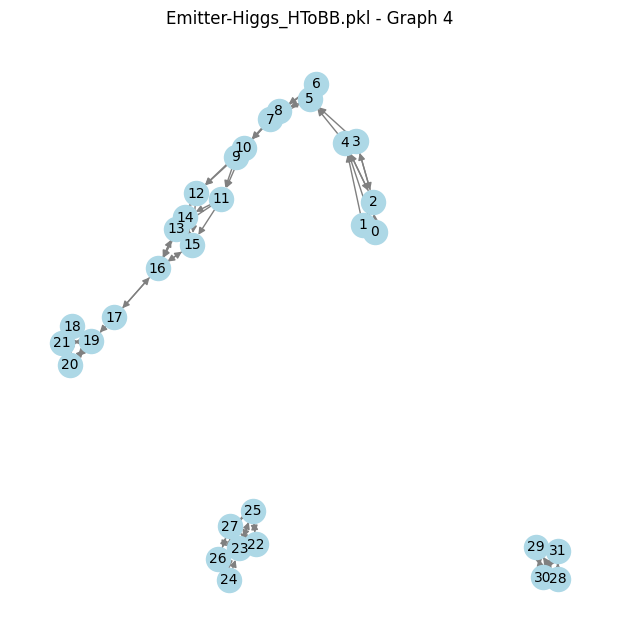

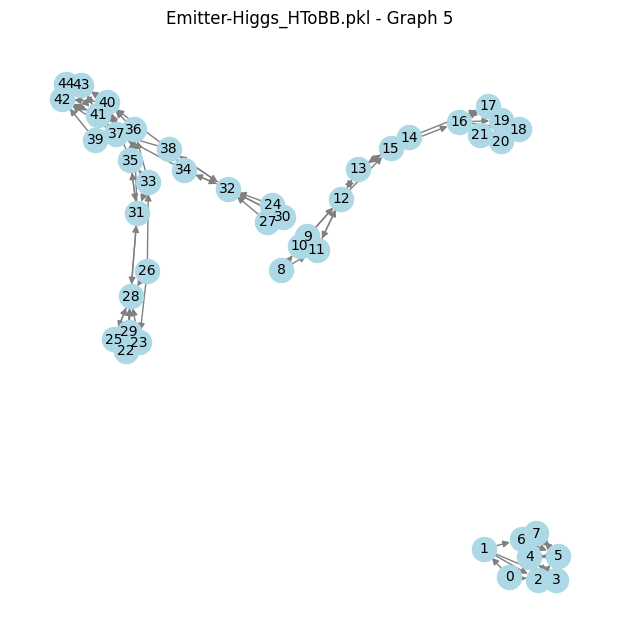

Loading graphs from: Emitter-Higgs_HToCC.pkl


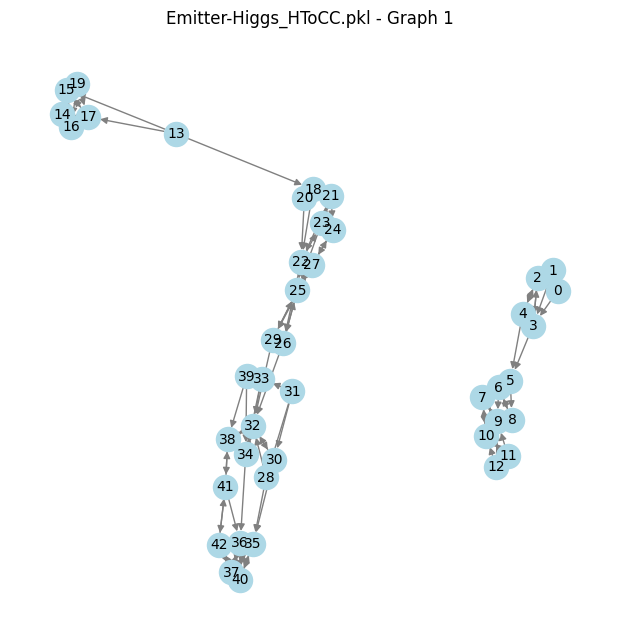

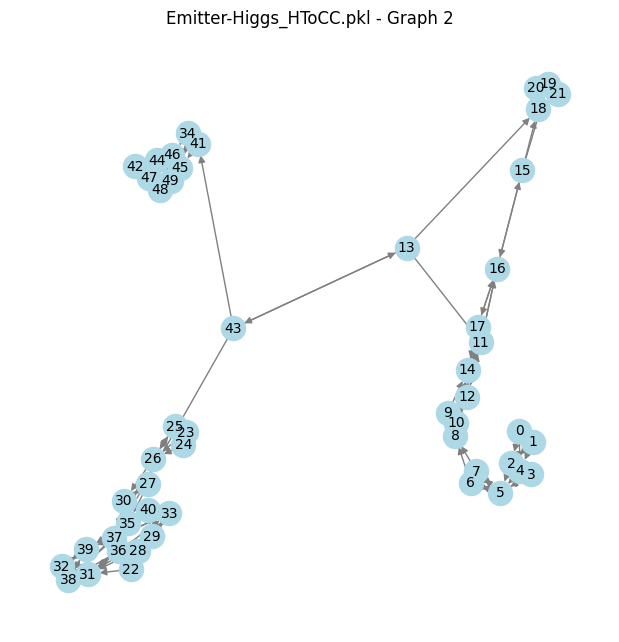

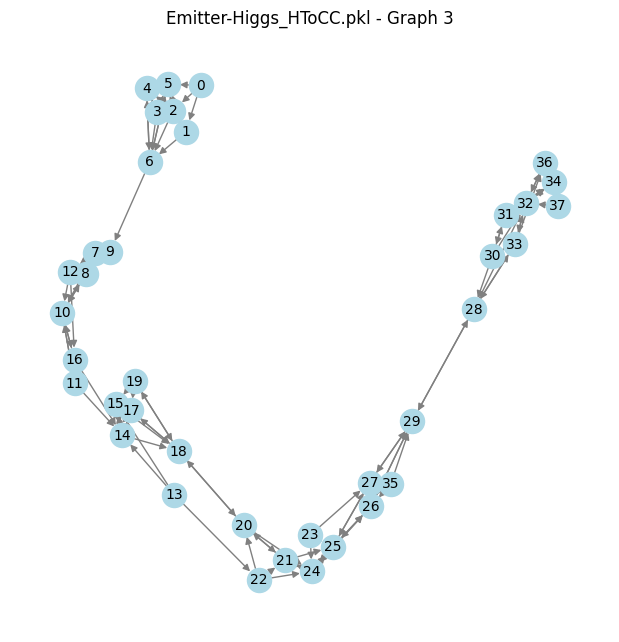

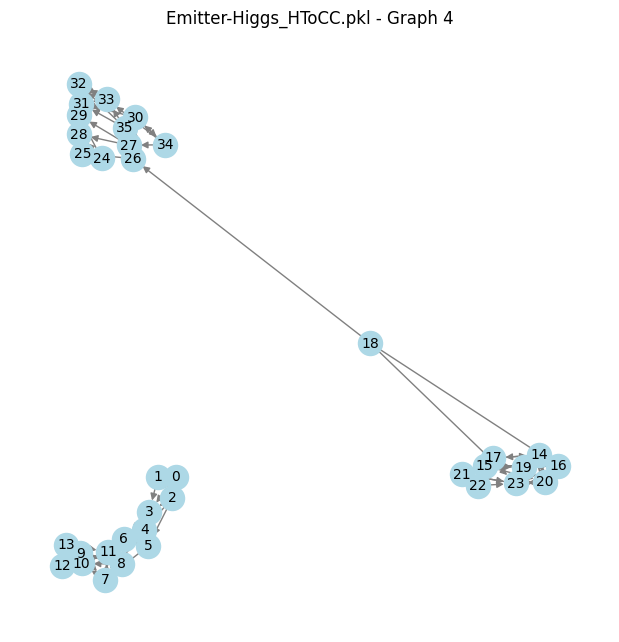

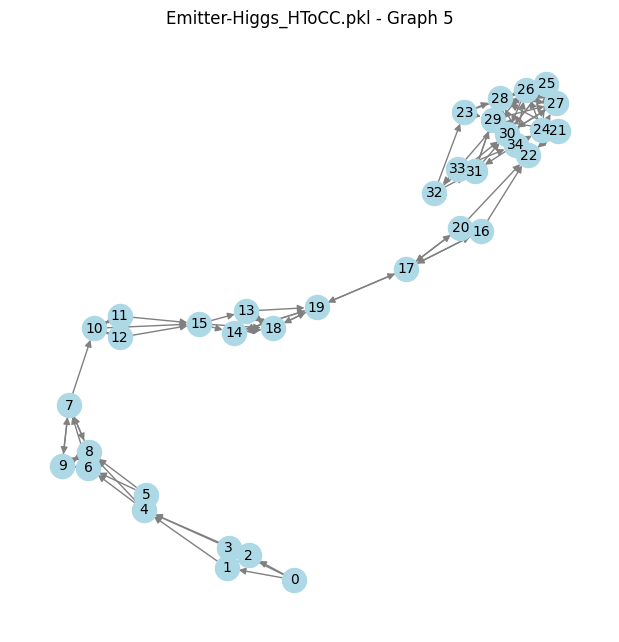

Loading graphs from: Emitter-Higgs_HToGG.pkl


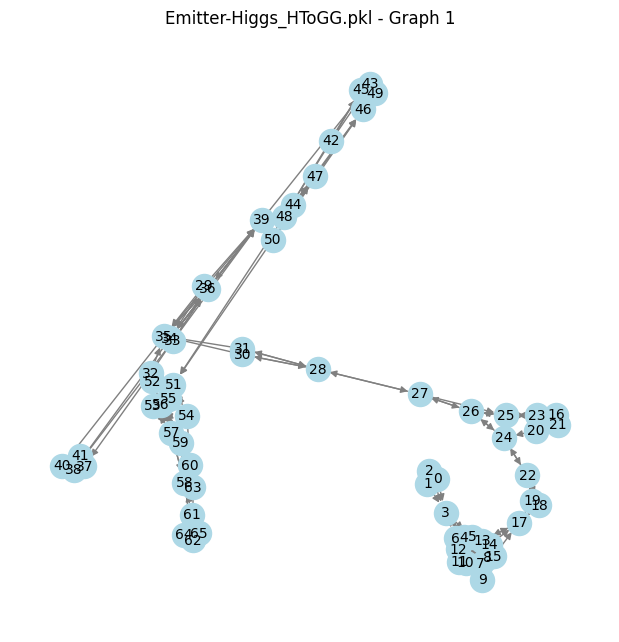

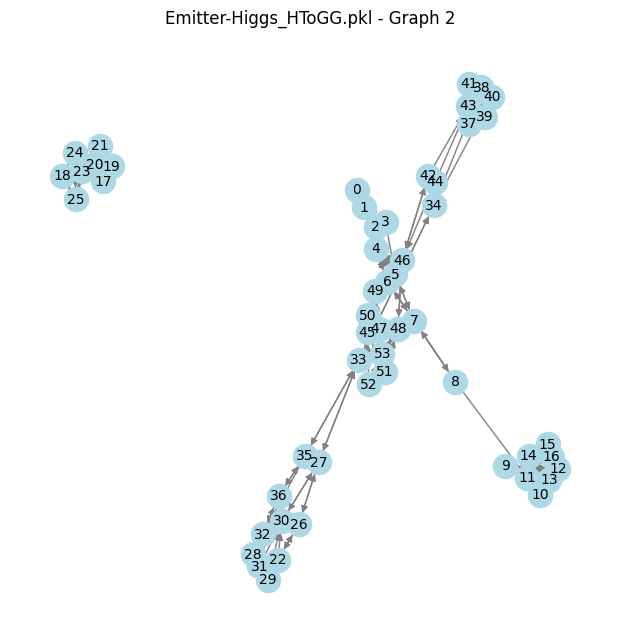

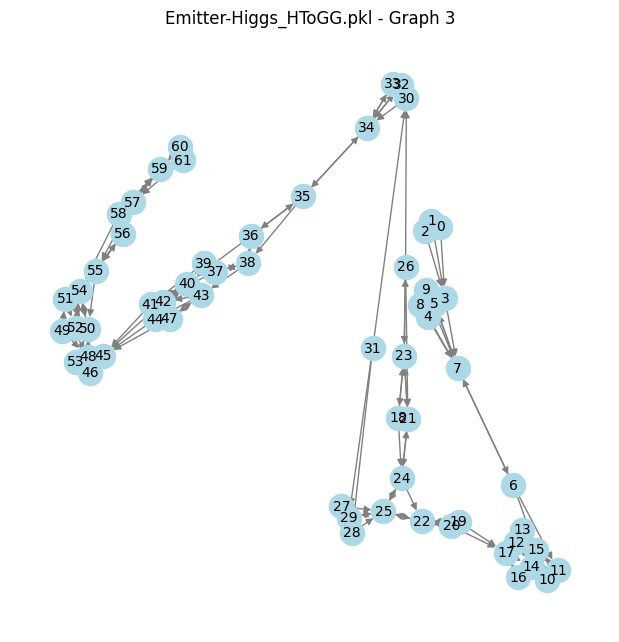

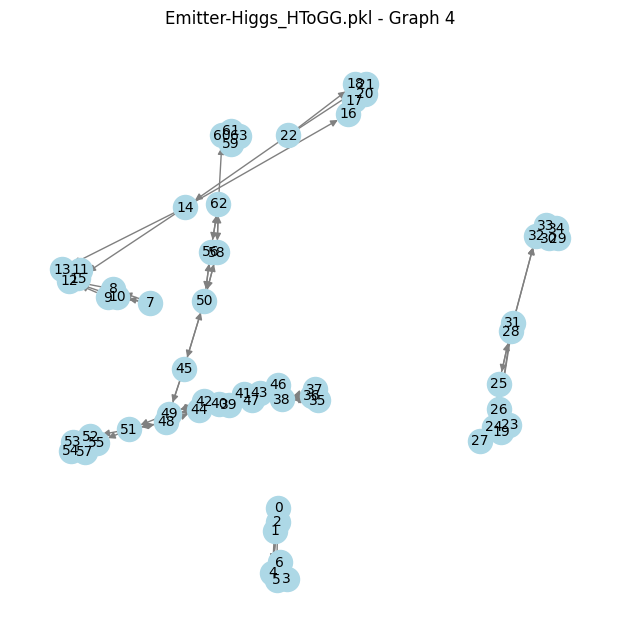

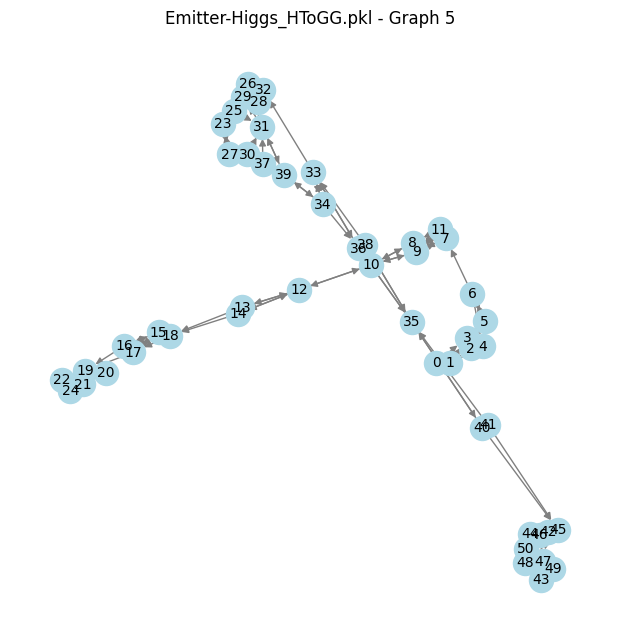

Loading graphs from: Emitter-Higgs_HToWW2Q1L.pkl


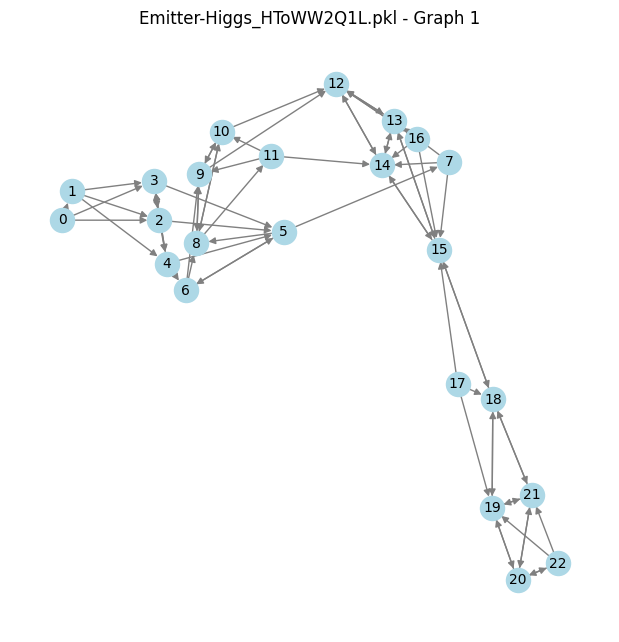

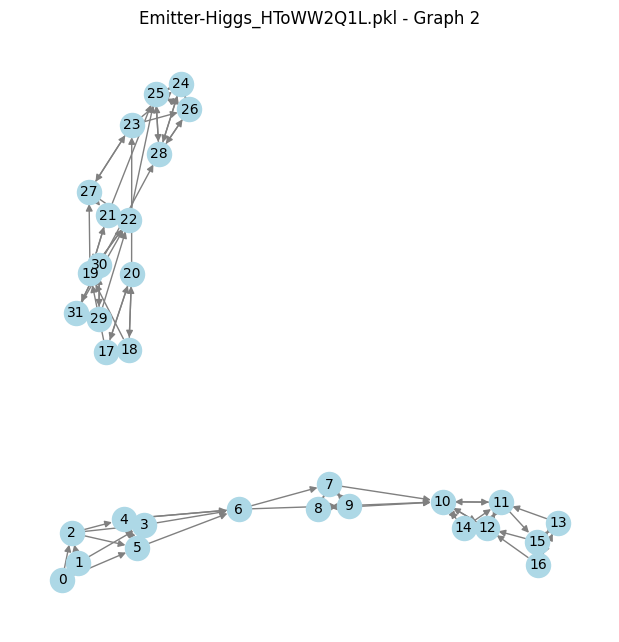

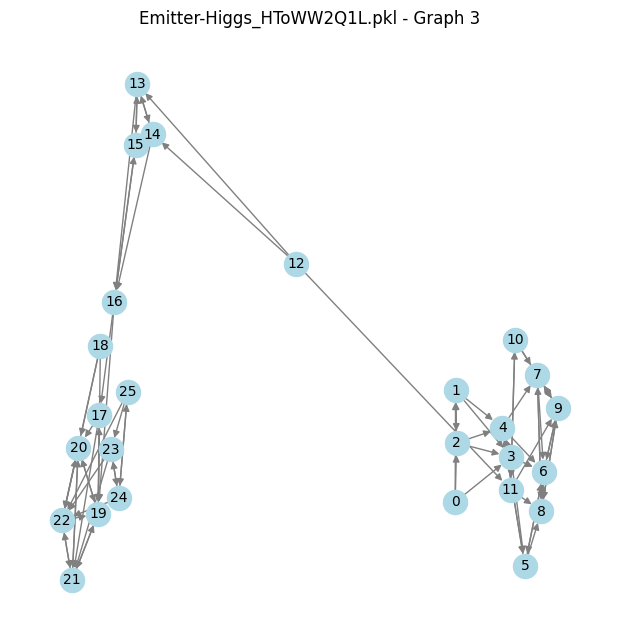

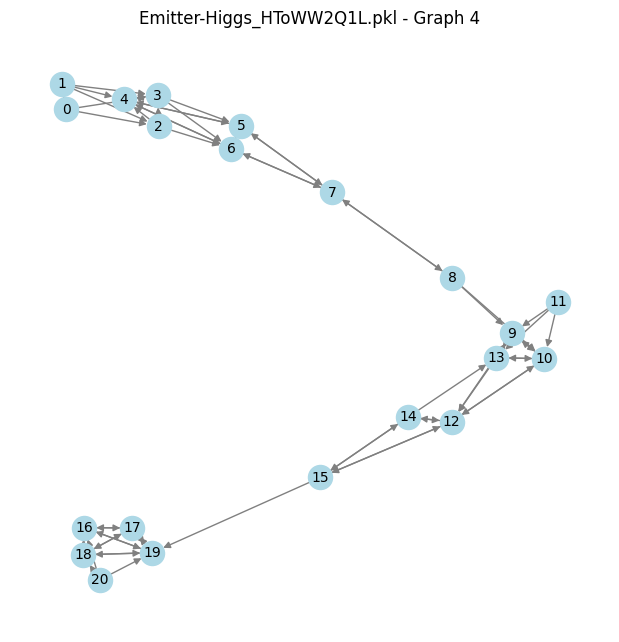

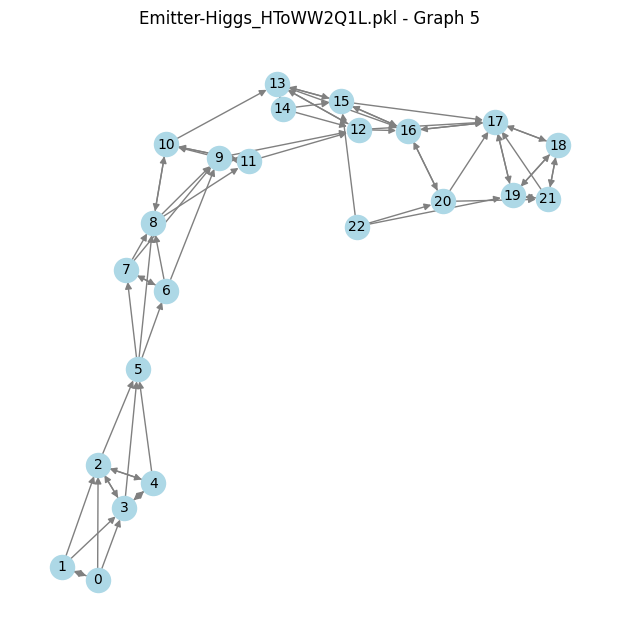

Loading graphs from: Emitter-Higgs_HToWW4Q.pkl


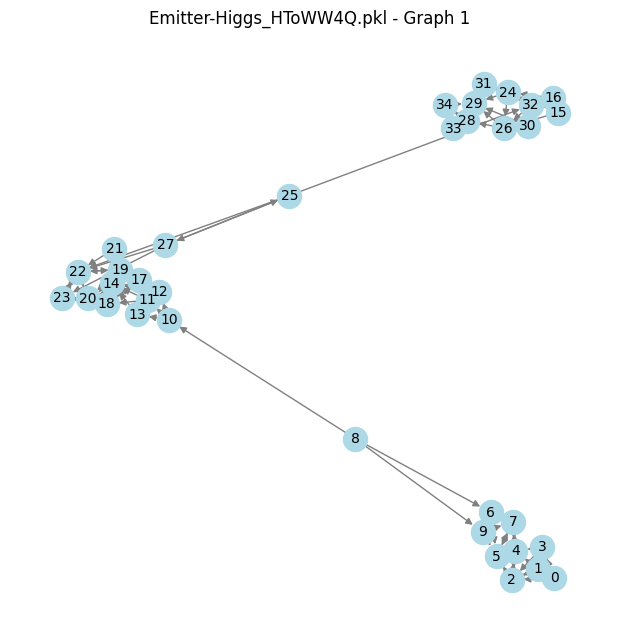

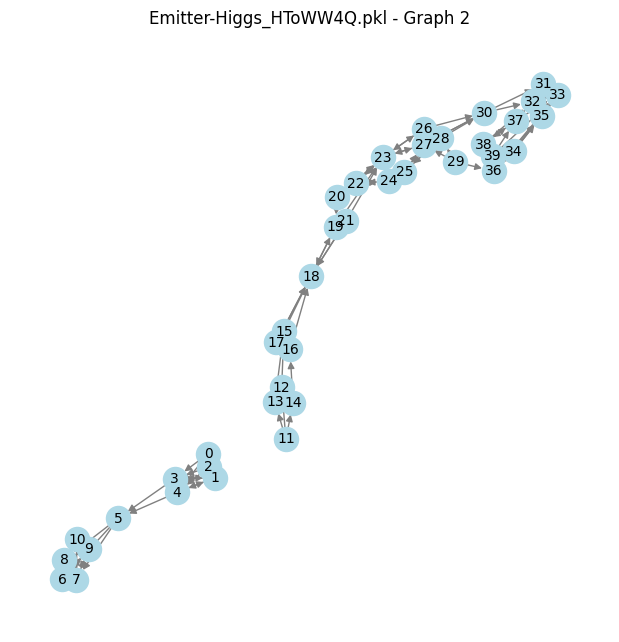

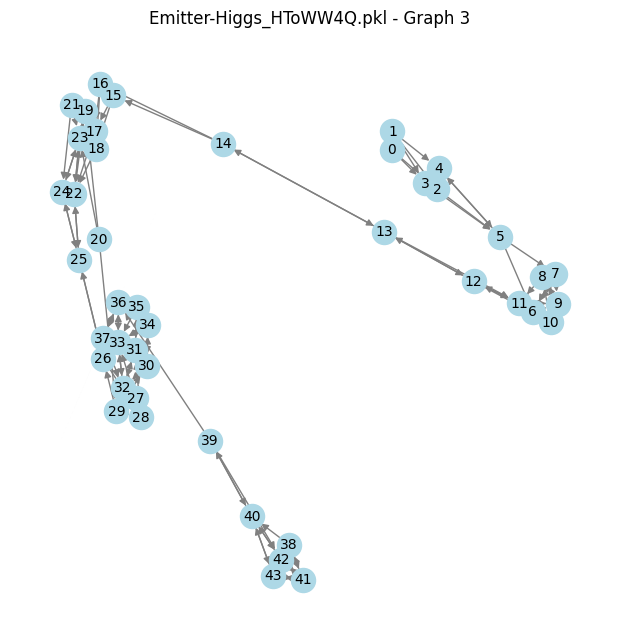

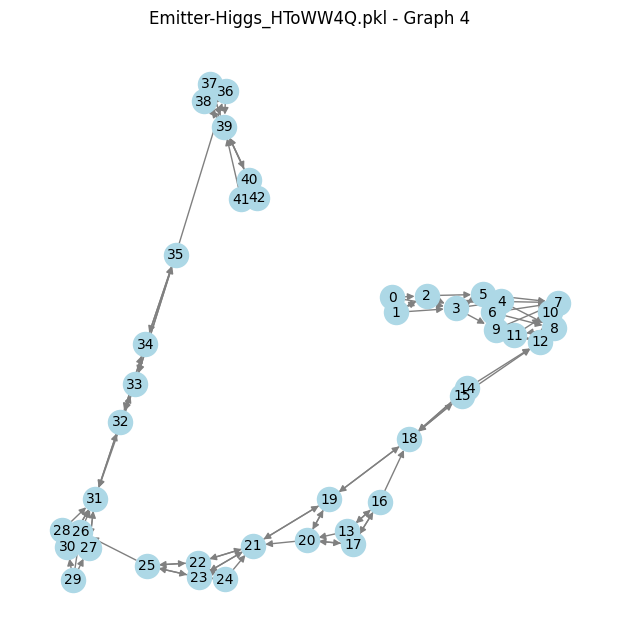

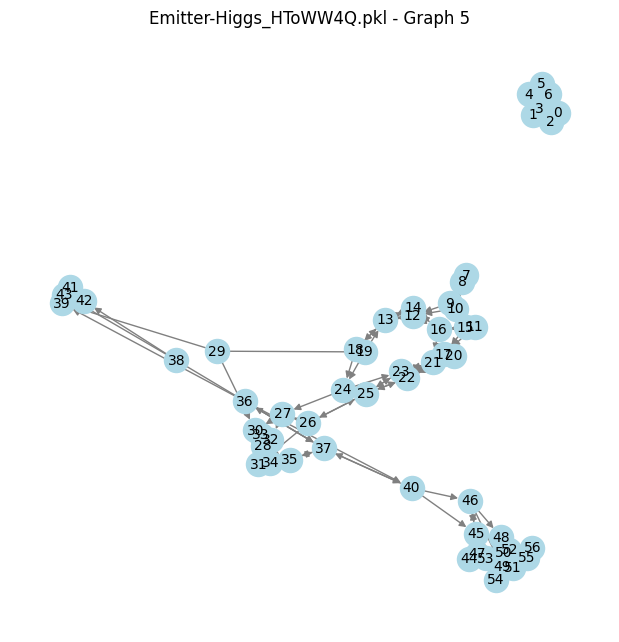

Loading graphs from: Emitter-QCD_ZJetsToNuNu.pkl


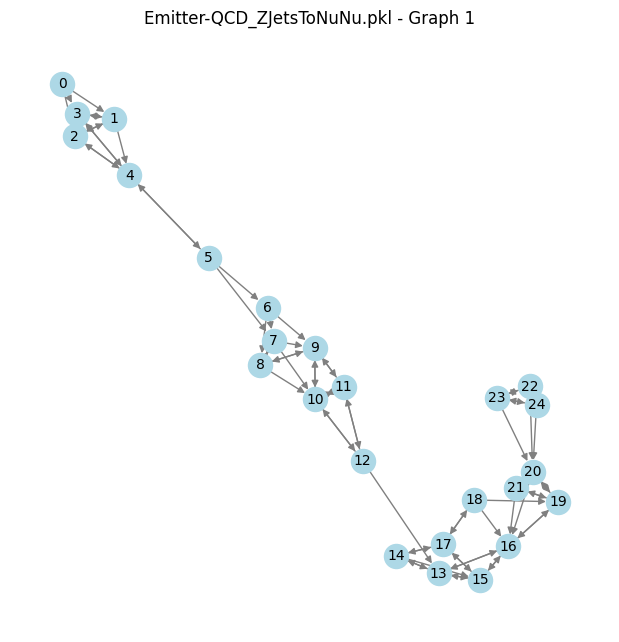

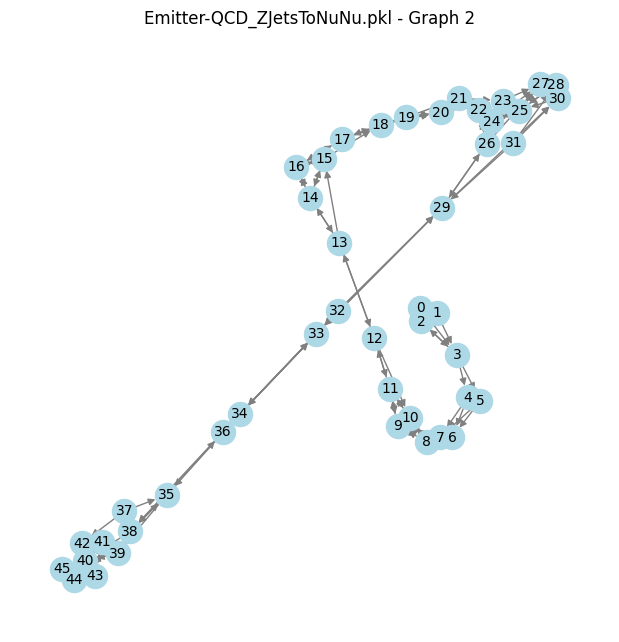

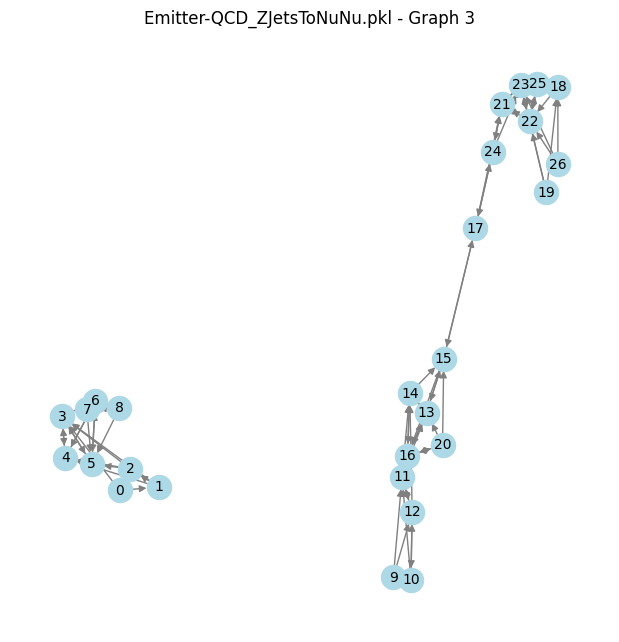

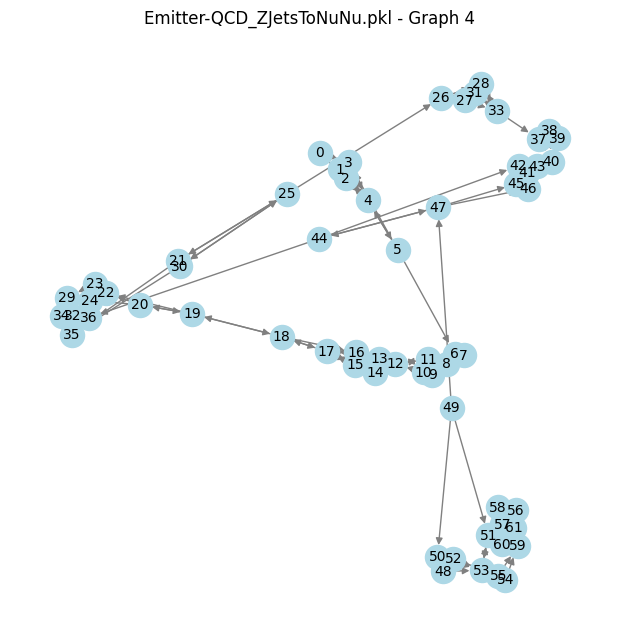

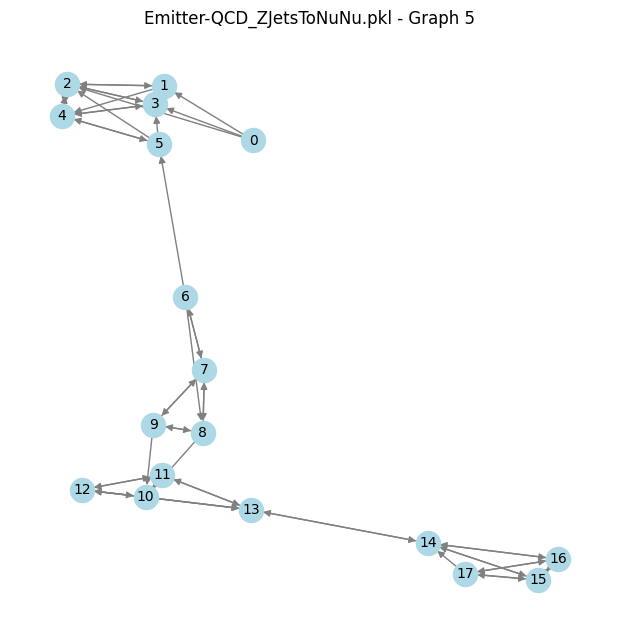

Loading graphs from: Emitter-Top_TTBar.pkl


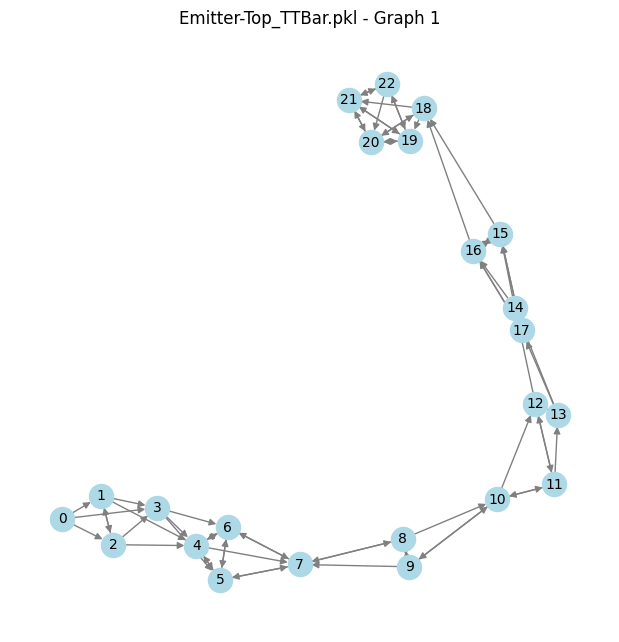

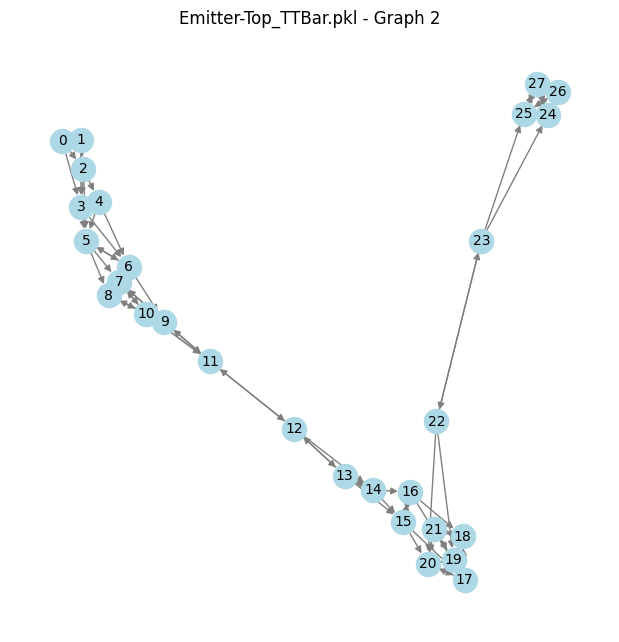

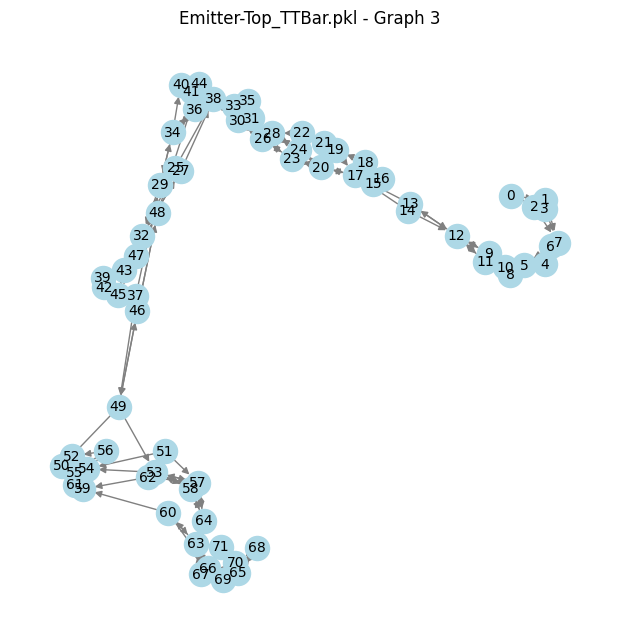

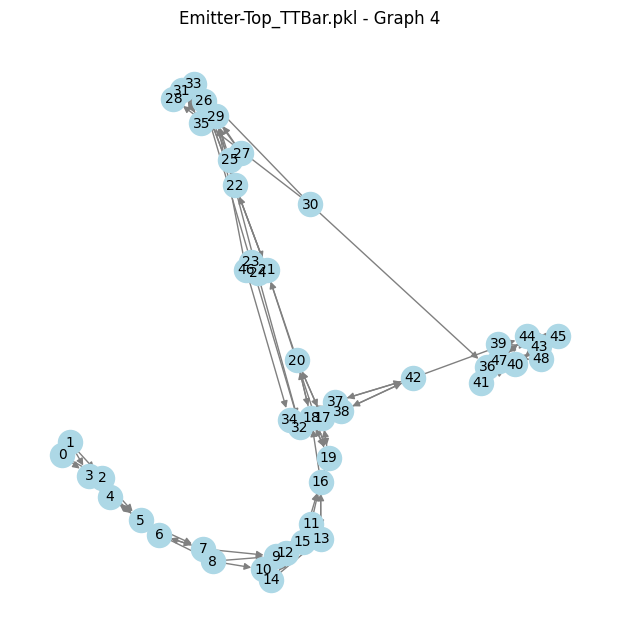

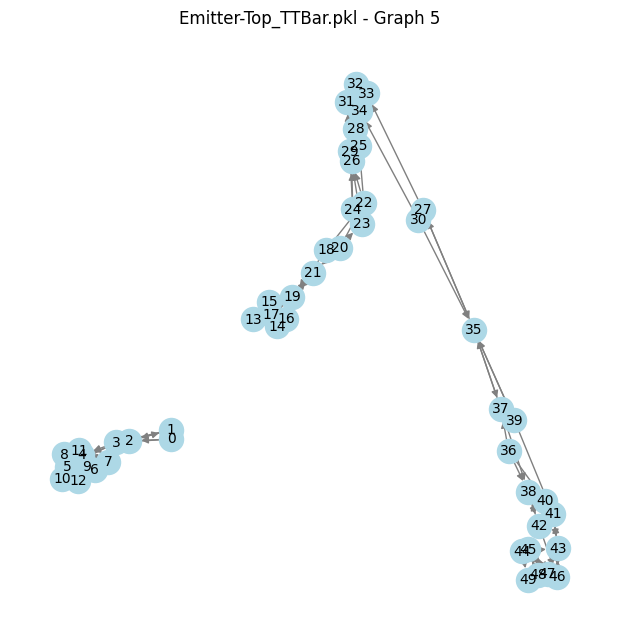

Loading graphs from: Emitter-Top_TTBarLep.pkl


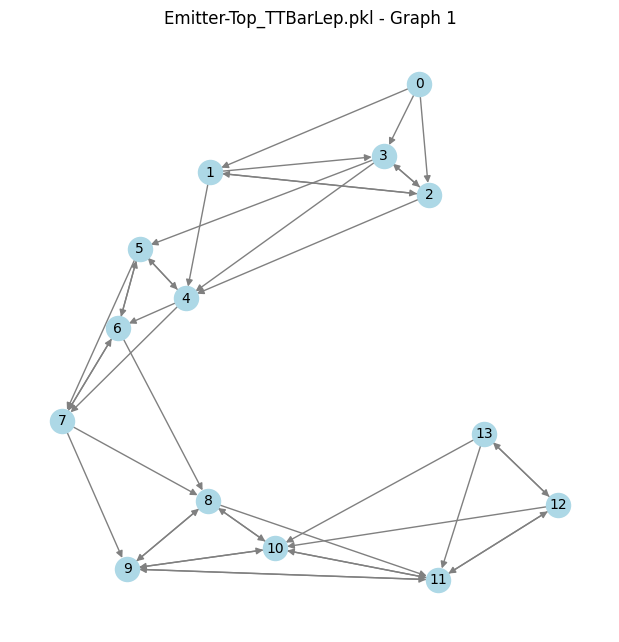

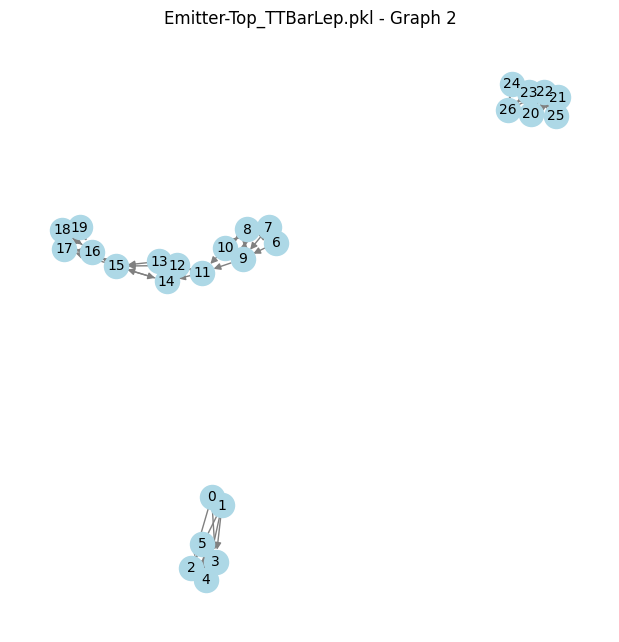

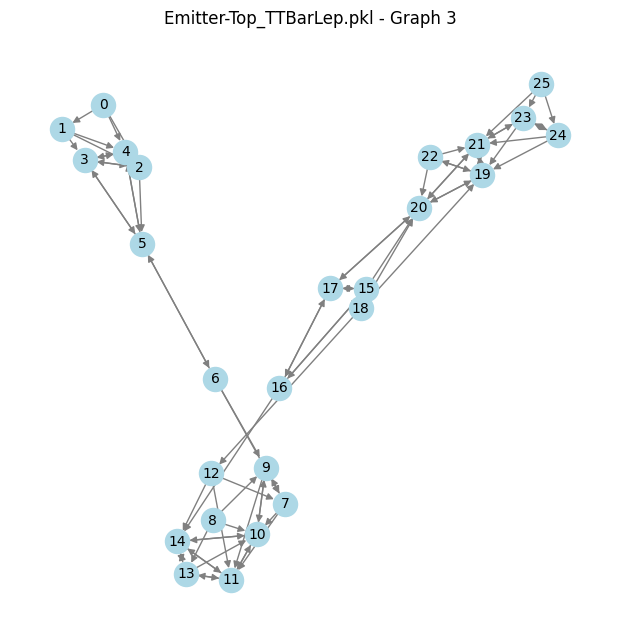

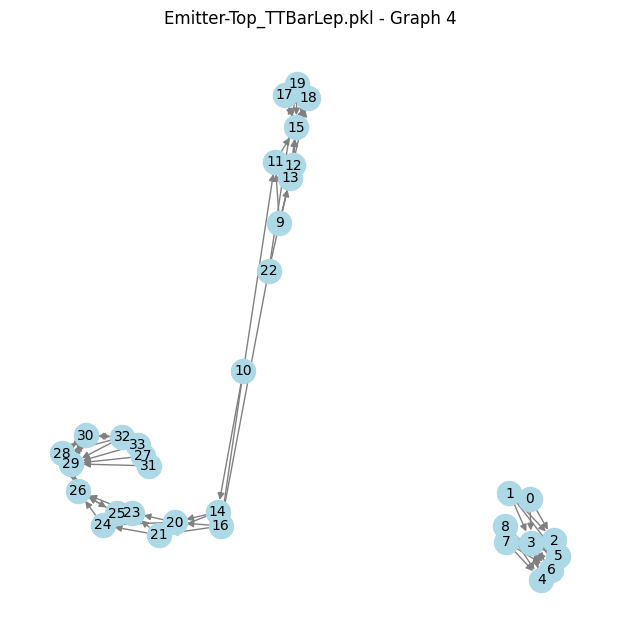

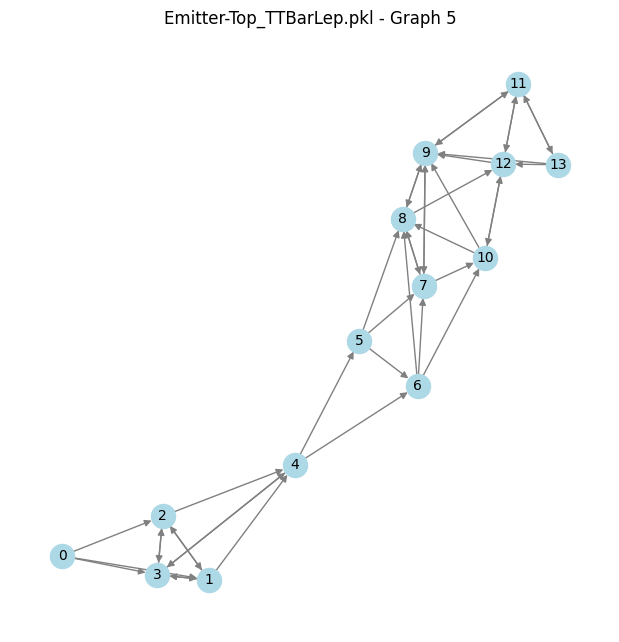

Loading graphs from: Emitter-Vector_WToQQ.pkl


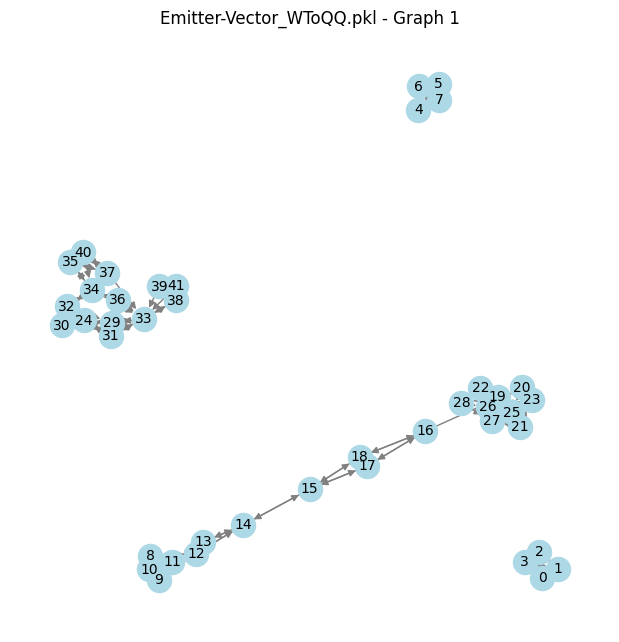

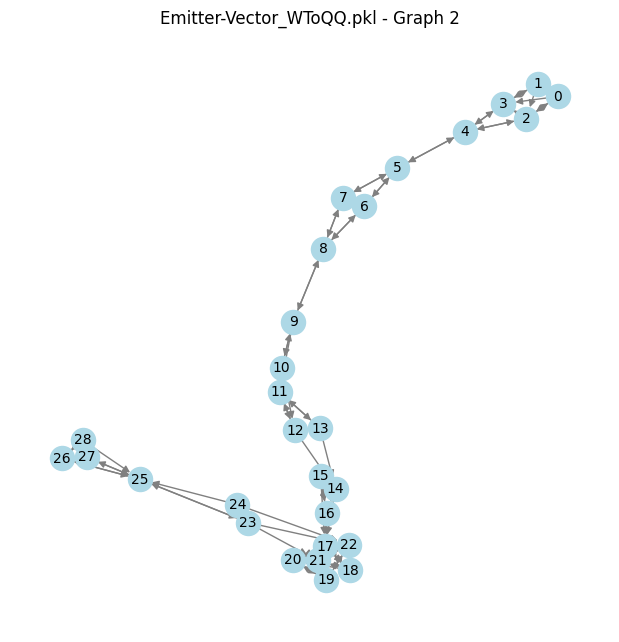

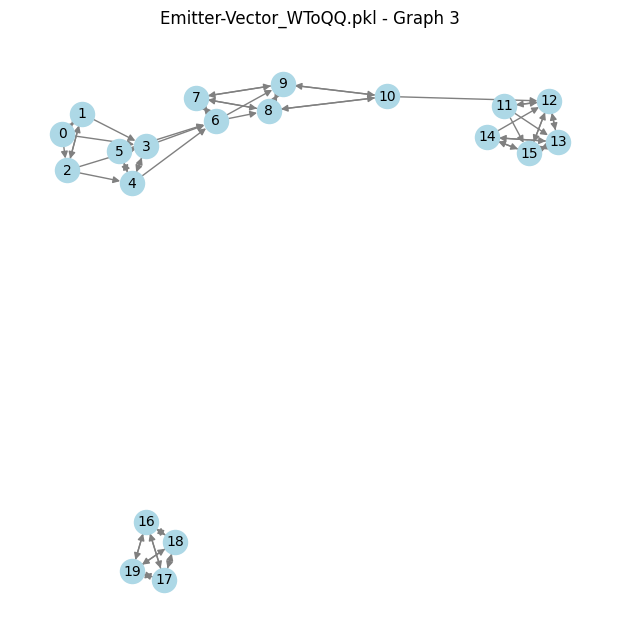

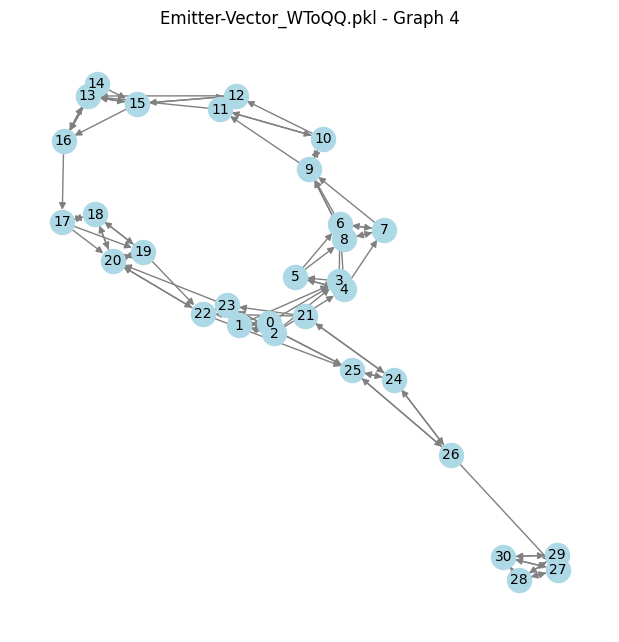

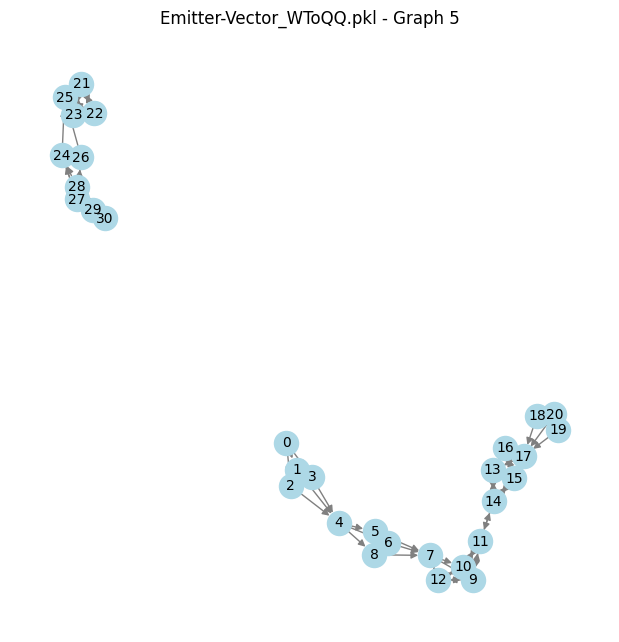

Loading graphs from: Emitter-Vector_ZToQQ.pkl


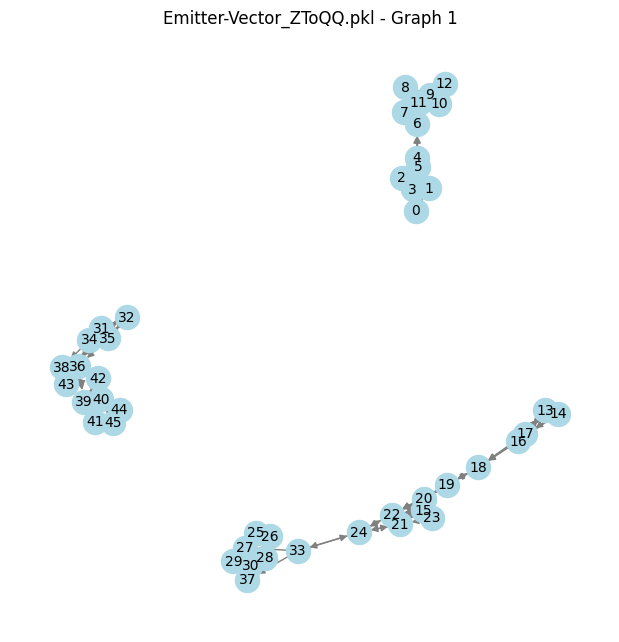

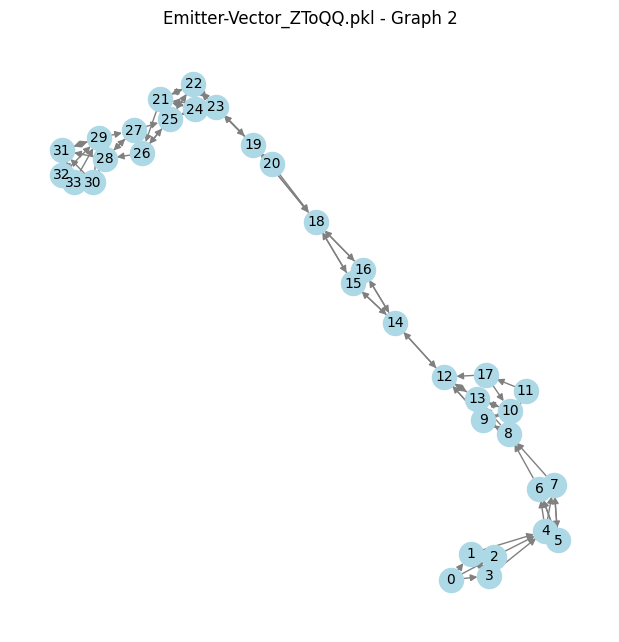

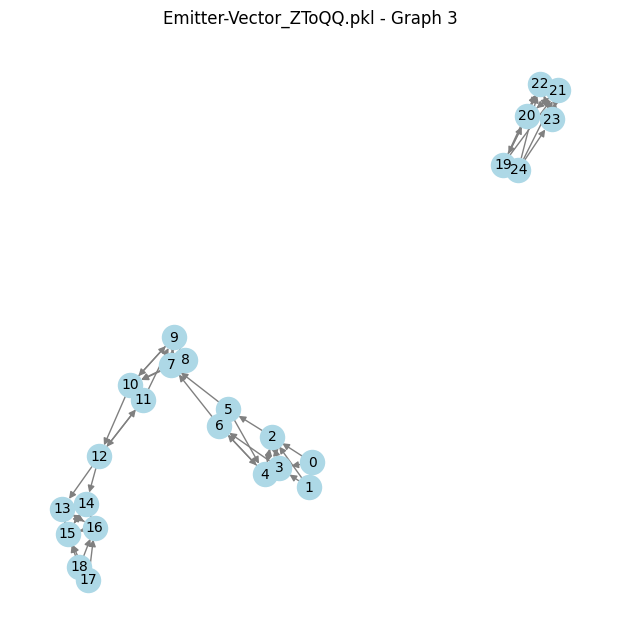

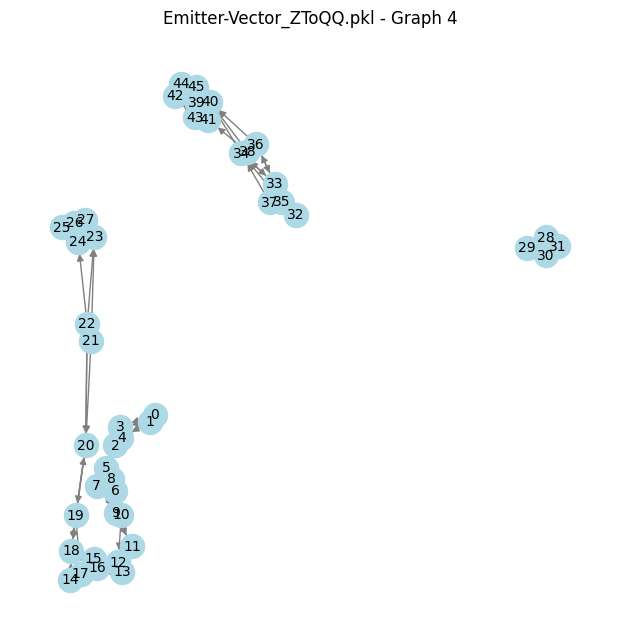

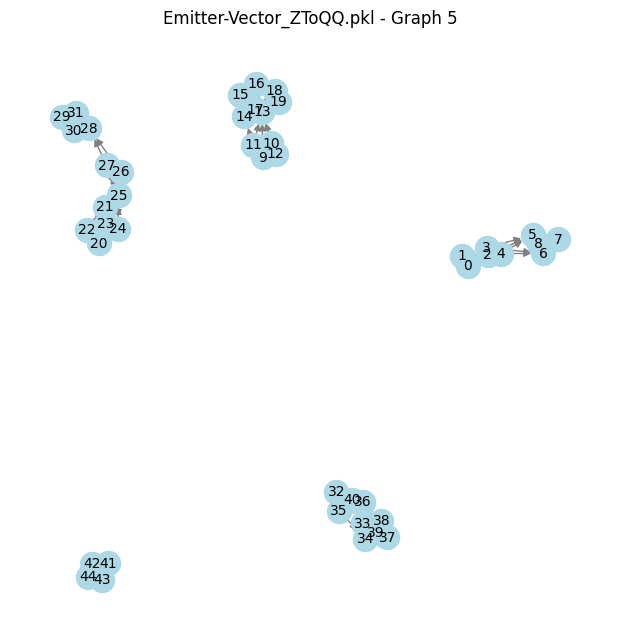

In [ ]:
import os
import pickle
import networkx as nx
import matplotlib.pyplot as plt

# Path to the directory containing the graph files
file_path = './data/Multi Level Jet Tagging/'

# Get a list of all files in the directory
files = sorted([f for f in os.listdir(file_path) if f.endswith('.pkl')])

# Function to visualize a DGL graph using NetworkX
def visualize_dgl_graph(dgl_graph, title):
    # Convert DGL graph to NetworkX graph
    nx_graph = dgl.to_networkx(dgl_graph)
    # Plot the graph
    plt.figure(figsize=(6, 6))
    pos = nx.spring_layout(nx_graph)  # Layout for better visualization
    nx.draw(nx_graph, pos, with_labels=True, node_color='lightblue', edge_color='gray', node_size=300, font_size=10)
    plt.title(title)
    plt.show()

# Loop through each file and visualize the first 5 graphs
for file in files:
    file_full_path = os.path.join(file_path, file)
    print(f"Loading graphs from: {file}")
    
    # Load the graphs from the file
    with open(file_full_path, 'rb') as f:
        graphs = pickle.load(f)
    
    # Visualize the first 5 graphs
    for i, graph in enumerate(graphs[:2]):
        visualize_dgl_graph(graph, title=f"{file} - Graph {i+1}")

# Maximum Number of Particles in a Single Jet

In [26]:
import os
import pickle

# Path to the directory containing the graph files
file_path = './data/Multi Level Jet Tagging/'

# Get a list of all files in the directory
files = sorted([f for f in os.listdir(file_path) if f.endswith('.pkl')])

# Dictionary to store the highest number of nodes for each jet type
jet_type_max_nodes = {}

# Variables to track the absolute highest number of nodes and corresponding graphs
absolute_max_nodes = 0
absolute_max_graphs_info = []  # List to store file names and graph indices with absolute max nodes

# Loop through each file
for file in files:
    file_full_path = os.path.join(file_path, file)
    print(f"Processing file: {file}")
    
    # Load the graphs from the file
    with open(file_full_path, 'rb') as f:
        graphs = pickle.load(f)
    
    # Variables to track the highest number of nodes for this jet type
    max_nodes_for_jet_type = 0
    max_graphs_info_for_jet_type = []  # List to store graph indices with max nodes for this jet type
    
    # Iterate through each graph in the file
    for idx, graph in enumerate(graphs):
        num_nodes = graph.number_of_nodes()  # Get the number of nodes in the graph
        
        # Check if this graph has a higher number of nodes than the current max for this jet type
        if num_nodes > max_nodes_for_jet_type:
            max_nodes_for_jet_type = num_nodes
            max_graphs_info_for_jet_type = [idx]  # Reset the list with new max
        elif num_nodes == max_nodes_for_jet_type:
            max_graphs_info_for_jet_type.append(idx)  # Add to the list if it matches the max
    
    # Store the highest number of nodes for this jet type
    jet_type_max_nodes[file] = {
        "max_nodes": max_nodes_for_jet_type,
        "graph_indices": max_graphs_info_for_jet_type
    }
    
    # Check if this jet type's max is the absolute highest so far
    if max_nodes_for_jet_type > absolute_max_nodes:
        absolute_max_nodes = max_nodes_for_jet_type
        absolute_max_graphs_info = [(file, idx) for idx in max_graphs_info_for_jet_type]  # Reset the list with new max
    elif max_nodes_for_jet_type == absolute_max_nodes:
        absolute_max_graphs_info.extend([(file, idx) for idx in max_graphs_info_for_jet_type])  # Add to the list if it matches the max

# Output the results for each jet type
print("\nHighest number of particles (nodes) for each jet type:")
for file, data in jet_type_max_nodes.items():
    print(f"- File: {file}, Max Nodes: {data['max_nodes']}, Graph Indices: {data['graph_indices']}")

# Output the absolute highest number of nodes across all jet types
print(f"\nAbsolute highest number of particles (nodes) across all jet types: {absolute_max_nodes}")
print(f"Number of graphs with this maximum: {len(absolute_max_graphs_info)}")
print("This maximum occurs in the following graphs:")
for file, idx in absolute_max_graphs_info:
    print(f"- File: {file}, Graph Index: {idx}")

Processing file: Emitter-Higgs_HToBB.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Processing file: Emitter-Higgs_HToCC.pkl
Processing file: Emitter-Higgs_HToGG.pkl
Processing file: Emitter-Higgs_HToWW2Q1L.pkl
Processing file: Emitter-Higgs_HToWW4Q.pkl
Processing file: Emitter-QCD_ZJetsToNuNu.pkl
Processing file: Emitter-Top_TTBar.pkl
Processing file: Emitter-Top_TTBarLep.pkl
Processing file: Emitter-Vector_WToQQ.pkl
Processing file: Emitter-Vector_ZToQQ.pkl



Highest number of particles (nodes) for each jet type:
- File: Emitter-Higgs_HToBB.pkl, Max Nodes: 136, Graph Indices: [6620]
- File: Emitter-Higgs_HToCC.pkl, Max Nodes: 94, Graph Indices: [3288]
- File: Emitter-Higgs_HToGG.pkl, Max Nodes: 129, Graph Indices: [5116]
- File: Emitter-Higgs_HToWW2Q1L.pkl, Max Nodes: 100, Graph Indices: [8761]
- File: Emitter-Higgs_HToWW4Q.pkl, Max Nodes: 106, Graph Indices: [7881]
- File: Emitter-QCD_ZJetsToNuNu.pkl, Max Nodes: 127, Graph Indices: [6064]
- File: Emitter-Top_TTBar.pkl, Max Nodes: 120, Graph Indices: [1518, 8734]
- File: Emitter-Top_TTBarLep.pkl, Max Nodes: 99, Graph Indices: [4801, 5542]
- File: Emitter-Vector_WToQQ.pkl, Max Nodes: 97, Graph Indices: [4211]
- File: Emitter-Vector_ZToQQ.pkl, Max Nodes: 105, Graph Indices: [8739]

Absolute highest number of particles (nodes) across all jet types: 136
Number of graphs with this maximum: 1
This maximum occurs in the following graphs:
- File: Emitter-Higgs_HToBB.pkl, Graph Index: 6620


# Percentage of Connected Components

Processing file: Emitter-Higgs_HToBB.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Higgs_HToBB.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              4404                 44.04
1                               2              3794                 37.94
2                               3              1437                 14.37
3                               4               314                  3.14
4                               5                48                  0.48
5                               6                 3                  0.03


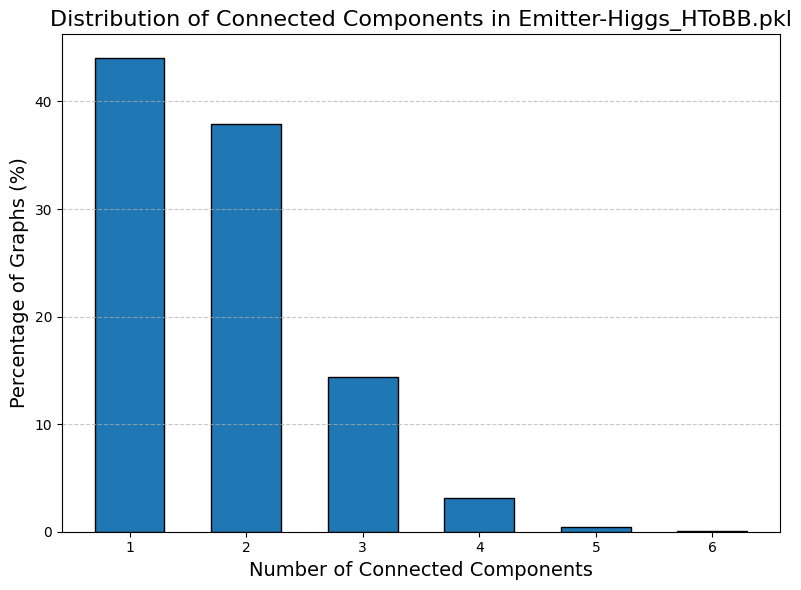

Processing file: Emitter-Higgs_HToCC.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Higgs_HToCC.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              4487                 44.87
1                               2              3824                 38.24
2                               3              1336                 13.36
3                               4               306                  3.06
4                               5                42                  0.42
5                               6                 4                  0.04
6                               7                 1                  0.01


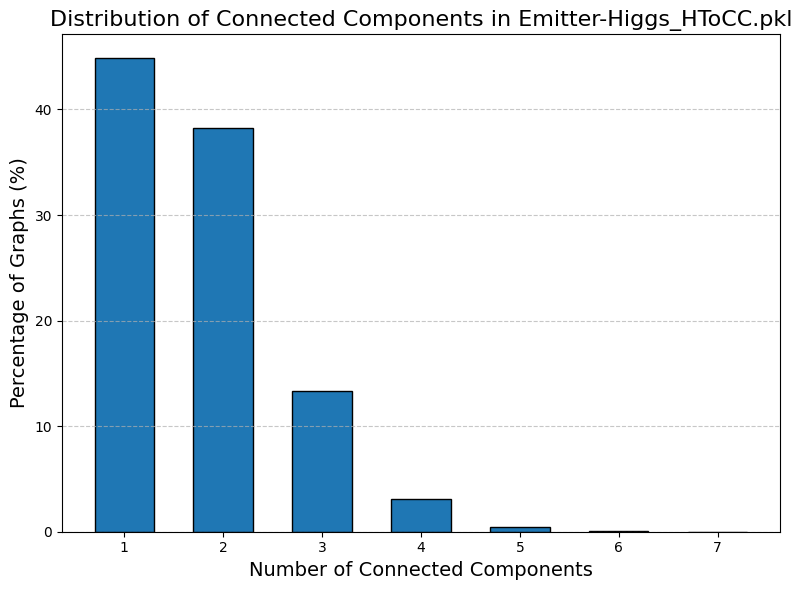

Processing file: Emitter-Higgs_HToGG.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Higgs_HToGG.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              4054                 40.54
1                               2              3686                 36.86
2                               3              1673                 16.73
3                               4               492                  4.92
4                               5                77                  0.77
5                               6                16                  0.16
6                               7                 2                  0.02


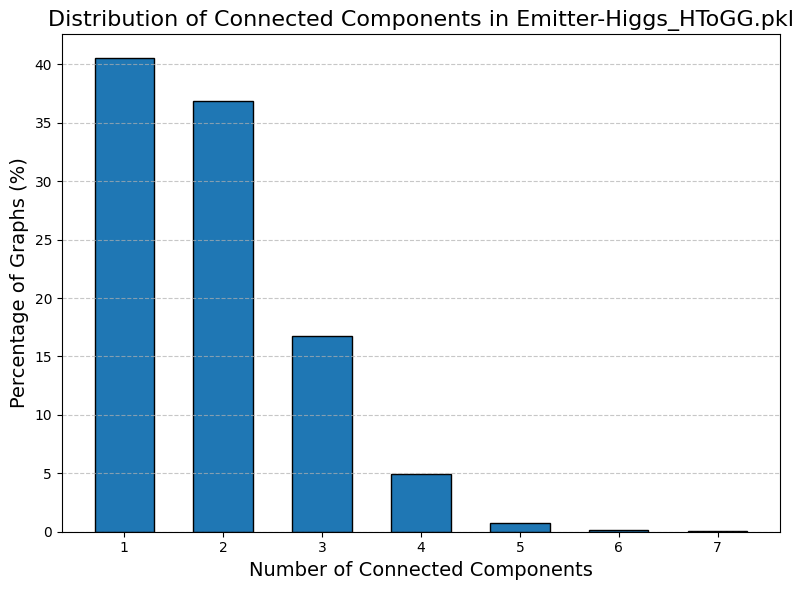

Processing file: Emitter-Higgs_HToWW2Q1L.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Higgs_HToWW2Q1L.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              5617             56.181236
1                               2              3309             33.096619
2                               3               918              9.181836
3                               4               141              1.410282
4                               5                12              0.120024
5                               6                 1              0.010002


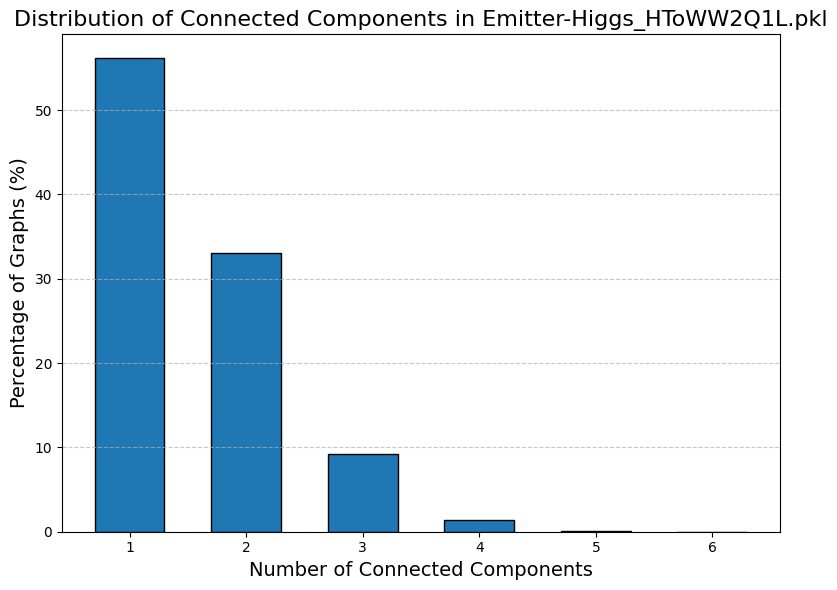

Processing file: Emitter-Higgs_HToWW4Q.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Higgs_HToWW4Q.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              4055                 40.55
1                               2              3785                 37.85
2                               3              1634                 16.34
3                               4               435                  4.35
4                               5                76                  0.76
5                               6                13                  0.13
6                               7                 2                  0.02


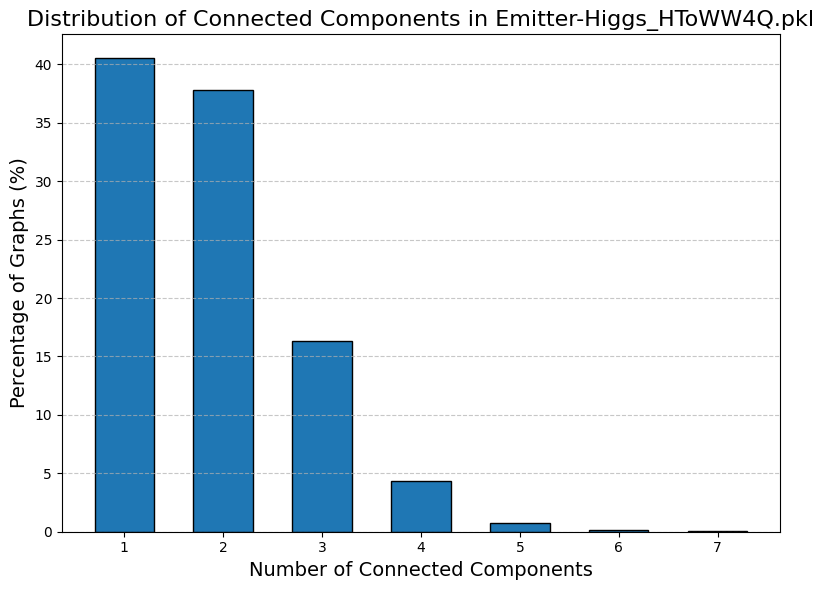

Processing file: Emitter-QCD_ZJetsToNuNu.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-QCD_ZJetsToNuNu.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              5396                 53.96
1                               2              3303                 33.03
2                               3              1021                 10.21
3                               4               227                  2.27
4                               5                47                  0.47
5                               6                 4                  0.04
6                               7                 2                  0.02


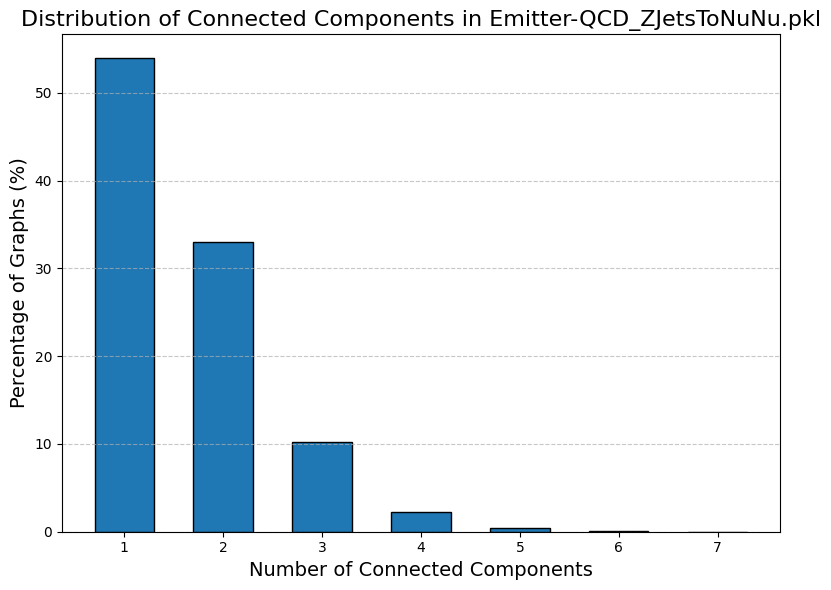

Processing file: Emitter-Top_TTBar.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Top_TTBar.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              5166                 51.66
1                               2              3493                 34.93
2                               3              1075                 10.75
3                               4               233                  2.33
4                               5                28                  0.28
5                               6                 5                  0.05


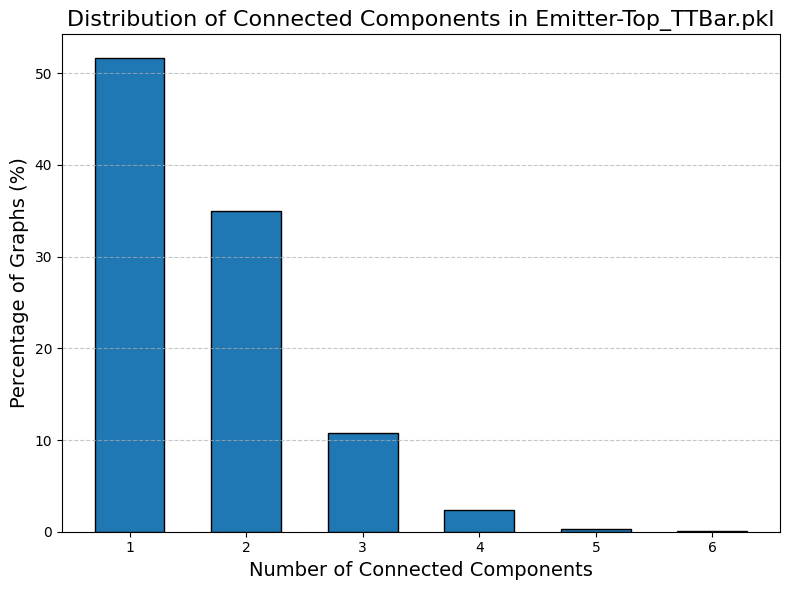

Processing file: Emitter-Top_TTBarLep.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Top_TTBarLep.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              6013             60.136014
1                               2              3084             30.843084
2                               3               780              7.800780
3                               4               110              1.100110
4                               5                11              0.110011
5                               6                 1              0.010001


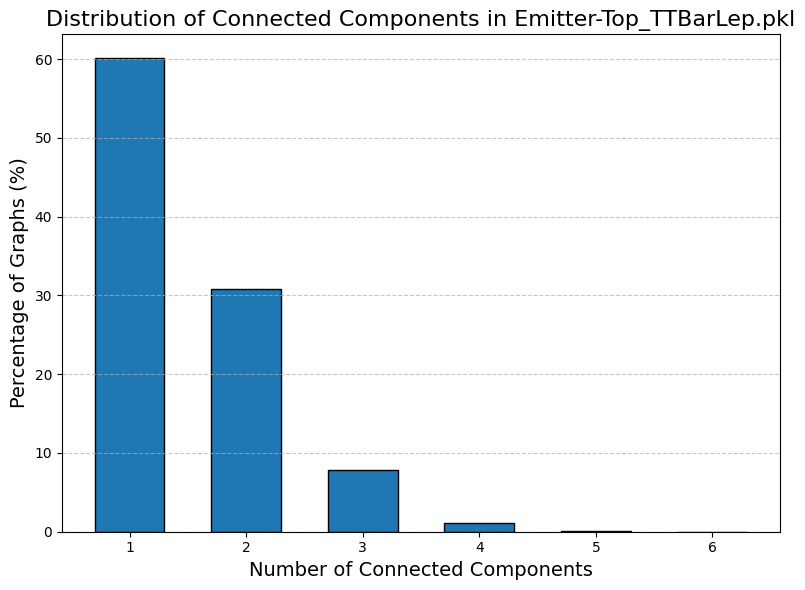

Processing file: Emitter-Vector_WToQQ.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Vector_WToQQ.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              4583                 45.83
1                               2              3667                 36.67
2                               3              1377                 13.77
3                               4               315                  3.15
4                               5                52                  0.52
5                               6                 5                  0.05
6                               7                 1                  0.01


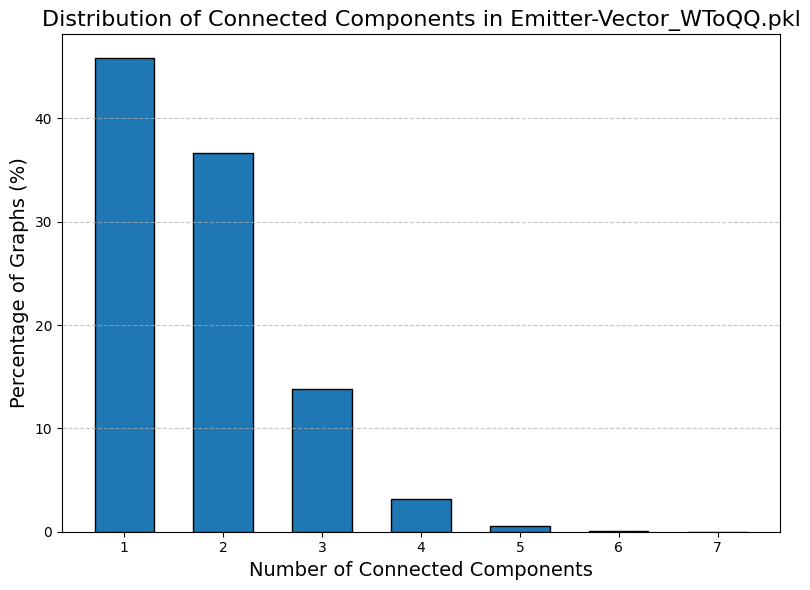

Processing file: Emitter-Vector_ZToQQ.pkl


/media/drive1/jettag/env_jet/lib/python3.10/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(io.BytesIO(b))


Statistics for Emitter-Vector_ZToQQ.pkl:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1              4674                 46.74
1                               2              3697                 36.97
2                               3              1287                 12.87
3                               4               300                  3.00
4                               5                40                  0.40
5                               6                 2                  0.02


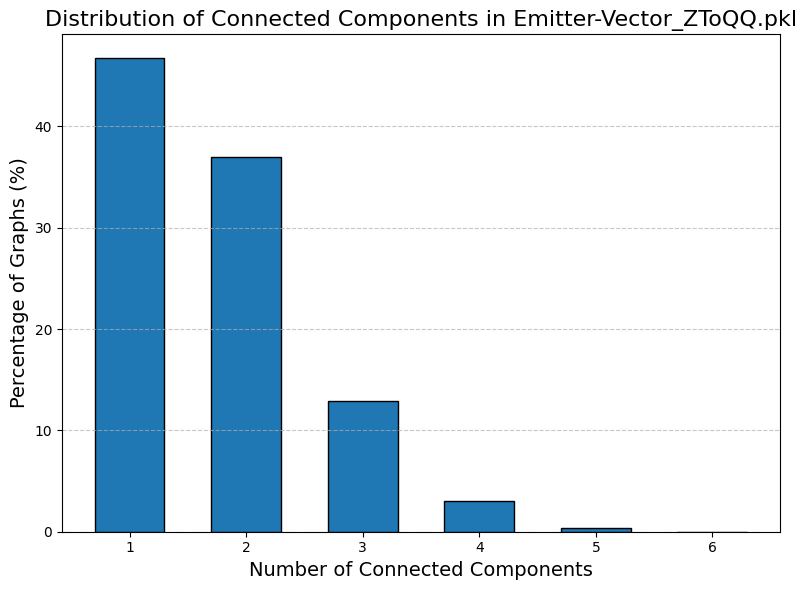

Combined Connected Components Frequency Analysis:
   Number of Connected Components  Number of Graphs  Percentage of Graphs
0                               1             48449             48.450454
1                               2             35642             35.643069
2                               3             12538             12.538376
3                               4              2873              2.873086
4                               5               433              0.433013
5                               6                54              0.054002
6                               7                 8              0.008000


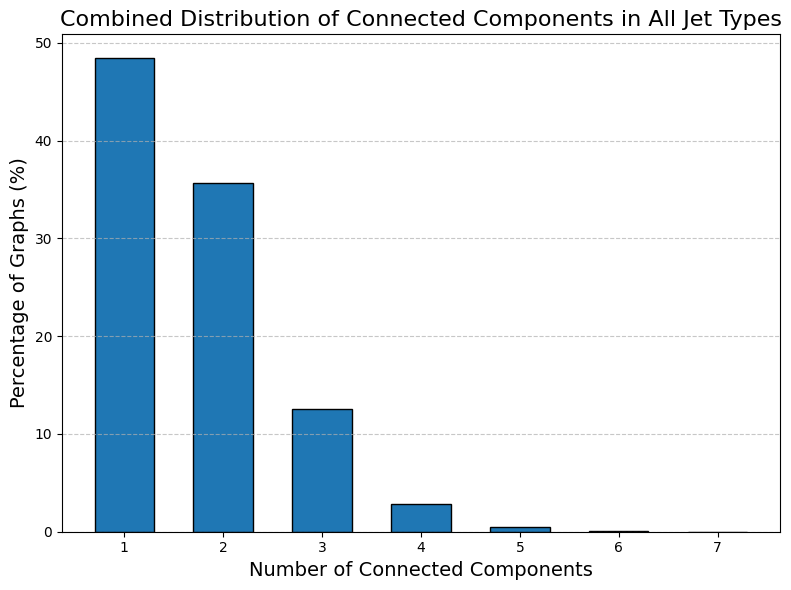

All results saved to ./all_connected_components_analysis.csv
All Connected Components Frequency Analysis:
    Number of Connected Components  Number of Graphs  Percentage of Graphs  \
0                                1              4404             44.040000   
1                                2              3794             37.940000   
2                                3              1437             14.370000   
3                                4               314              3.140000   
4                                5                48              0.480000   
..                             ...               ...                   ...   
67                               3             12538             12.538376   
68                               4              2873              2.873086   
69                               5               433              0.433013   
70                               6                54              0.054002   
71                               7  

In [5]:
import os
import pickle
import dgl
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt

# Path to the directory containing the graph files
file_path = './data/Multi Level Jet Tagging/'

# Get a list of all files in the directory
files = sorted([f for f in os.listdir(file_path) if f.endswith('.pkl')])

# Function to count connected components
def count_connected_components(dgl_graph):
    nx_graph = dgl.to_networkx(dgl_graph)  # Convert DGL graph to NetworkX
    undirected_graph = nx_graph.to_undirected()  # Convert to undirected graph
    return nx.number_connected_components(undirected_graph)  # Count the number of connected components

# Dictionary to store results for each jet type
jet_type_results = {}

# List to store raw data for combined analysis
all_graph_analysis = []

# DataFrame to store all results
all_results = pd.DataFrame()

# Loop through each file
for file in files:
    file_full_path = os.path.join(file_path, file)
    print(f"Processing file: {file}")
    
    # Load the graphs from the file
    with open(file_full_path, 'rb') as f:
        graphs = pickle.load(f)
    
    # Analyze all graphs for this jet type
    graph_analysis = [count_connected_components(graph) for graph in graphs]
    
    # Store the raw data for combined analysis
    all_graph_analysis.extend(graph_analysis)
    
    # Calculate frequency distribution of connected components for this jet type
    component_counts = pd.Series(graph_analysis).value_counts().sort_index()
    component_percentages = (component_counts / len(graph_analysis)) * 100

    # Display the statistics for the current jet type
    print(f"Statistics for {file}:")
    jet_results_df = pd.DataFrame({
        'Number of Connected Components': component_counts.index,
        'Number of Graphs': component_counts.values,
        'Percentage of Graphs': component_percentages.values
    })
    print(jet_results_df)

    # Append individual jet type results to the combined DataFrame
    jet_results_df['Jet Type'] = file
    all_results = pd.concat([all_results, jet_results_df], ignore_index=True)

    # Plot the histogram for this jet type
    plt.figure(figsize=(8, 6))
    plt.bar(component_counts.index, component_percentages.values, width=0.6, edgecolor='black')
    plt.xlabel('Number of Connected Components', fontsize=14)
    plt.ylabel('Percentage of Graphs (%)', fontsize=14)
    plt.title(f'Distribution of Connected Components in {file}', fontsize=16)
    plt.xticks(component_counts.index)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Calculate combined frequency distribution of connected components
combined_component_counts = pd.Series(all_graph_analysis).value_counts().sort_index()
combined_component_percentages = (combined_component_counts / len(all_graph_analysis)) * 100

# Ensure all unique values are included (even if their count is 0)
max_components = max(all_graph_analysis)
all_possible_components = range(1, max_components + 1)
combined_component_counts = combined_component_counts.reindex(all_possible_components, fill_value=0)
combined_component_percentages = combined_component_percentages.reindex(all_possible_components, fill_value=0)

# Display the combined statistics
print("Combined Connected Components Frequency Analysis:")
combined_results_df = pd.DataFrame({
    'Number of Connected Components': combined_component_counts.index,
    'Number of Graphs': combined_component_counts.values,
    'Percentage of Graphs': combined_component_percentages.values
})
print(combined_results_df)

# Append combined results to the all_results DataFrame
combined_results_df['Jet Type'] = 'Combined'
all_results = pd.concat([all_results, combined_results_df], ignore_index=True)

# Plot the combined histogram
plt.figure(figsize=(8, 6))
plt.bar(combined_component_counts.index, combined_component_percentages.values, width=0.6, edgecolor='black')
plt.xlabel('Number of Connected Components', fontsize=14)
plt.ylabel('Percentage of Graphs (%)', fontsize=14)
plt.title('Combined Distribution of Connected Components in All Jet Types', fontsize=16)
plt.xticks(combined_component_counts.index)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

# Save all results to a single CSV file
csv_path = './all_connected_components_analysis.csv'
all_results.to_csv(csv_path, index=False)
print(f"All results saved to {csv_path}")

# Display the combined DataFrame
print("All Connected Components Frequency Analysis:")
print(all_results)
